# Image color correction based on sclera segmentation

Can be applied to MST images since the sclera is visible

Taken from "Colour balancing using sclera colour"

The average sclera value in CIE xyY colour space for x and y is 0.369 and 0.367, with a relative standard deviation of 2.41 and 2.43%.

1. Scele illuminant estimation: the ratio between computed pixel average colour of the sclera region c̄sclera and the reference average sclera colour under the canonical illuminant. Formula: I = c̄sclera/ρsclera. This sould output I = (Ix, Iy, Iz)

2. Chromatic adaptation: each pixel in
the image is colour corrected using the von Kries model

In [3]:

import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import sys
import cv2
import numpy as np
import matplotlib.pyplot as plt
import mediapipe as mp

sys.path.append('../')
from utils import color_correction_utils
from utils import baseline_utils
from utils import sclera_segmentation_utils

sys.path.append('/home/dasec-notebook/Thesis/sclera-segmentation/src')
import sclera # NOTE: This is the custom module for sclera segmentation taken from https://github.com/wkabbani/sclera-segmentation

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Otsu segmentation on a full image

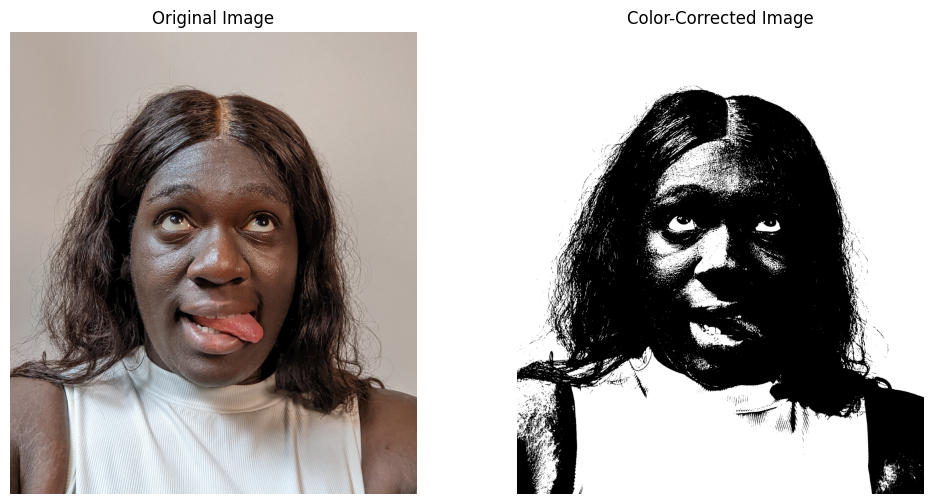

In [76]:

image = cv2.imread('/home/dasec-notebook/Thesis/Datasets/mst-e_data/mst-e_data_portrait/subject_4/PXL_20220922_161932128.jpg')

# Perform Otsu's thresholding
thresholded_image = color_correction_utils.otsu_segmentation(image)

# plot original and thresholded images

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(thresholded_image, cv2.COLOR_BGR2RGB))
plt.title('Color-Corrected Image')
plt.axis('off')

plt.show()



# Sclera segmentation and mean sclera RGB extraction

1. Segments sclera based on Wassim's approach
2. Adds additional Otsu segmentation
3. Calculates the color and exposure illuminants

[48.    4.75  0.  ]
[32.75  8.25  1.25]


I0000 00:00:1733315891.562954   17010 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1733315891.574282   48285 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.0.9-0ubuntu0.2), renderer: Mesa Intel(R) HD Graphics 620 (KBL GT2)
W0000 00:00:1733315891.587360   48280 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1733315891.641450   48280 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


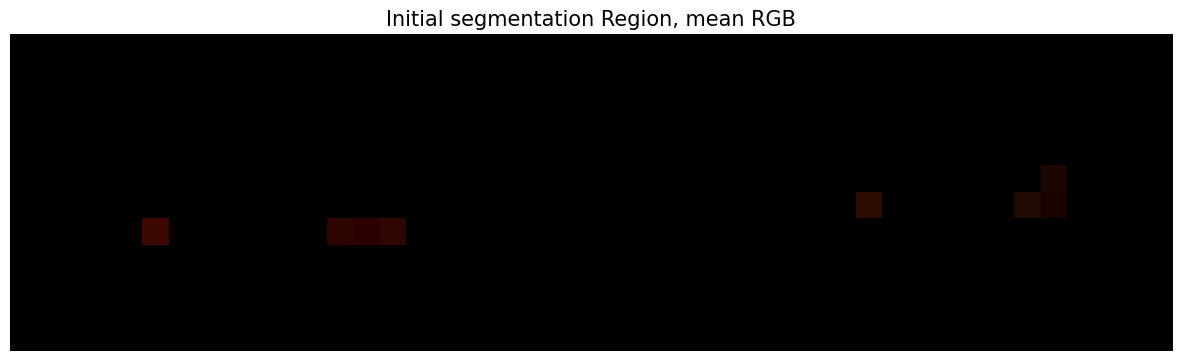

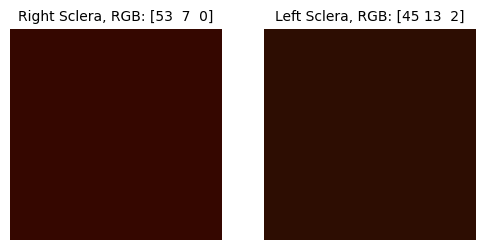

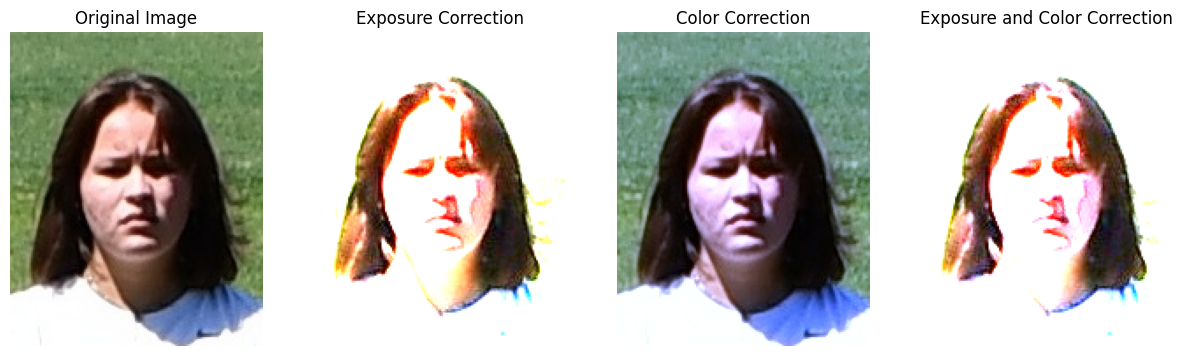

In [12]:
# Assuming sclera extraction functions are defined elsewhere
# Example: sclera.get_sclera_location, sclera.get_sclera_pixels

# Constants for the reference average sclera color in the CIE xyY color space
reference_sclera_xy = (0.369, 0.367)
relative_std_dev = (2.41 / 100, 2.43 / 100) 

# Load the image
image_path = '/home/dasec-notebook/Thesis/Datasets/CHROMA-FIT-Dataset/DATA_CROPPED_PORTRAIT2/00022/DSC_0291.JPG'
# image_path = '/home/dasec-notebook/Thesis/Datasets/mst-e_data/mst-e_data_portrait/subject_13/PXL_20220922_140956208.jpg'
# image_path = '/home/dasec-notebook/Thesis/Datasets/mst-e_data/mst-e_data_portrait/subject_9/PXL_20220922_140315071.PORTRAIT.jpg'
# image_path = '/home/dasec-notebook/Thesis/Datasets/mst-e_data/mst-e_data_portrait/subject_13/PXL_20220922_140951373.jpg'
# image_path = '/home/dasec-notebook/Thesis/Datasets/mst-e_data/mst-e_data_portrait/subject_13/PXL_20220922_141142245.jpg'

image = cv2.imread(image_path)

if image is None:
    raise ValueError("Image not found at the specified path!")

height, width, _ = image.shape

mp_face_mesh = mp.solutions.face_mesh
l_locations, r_locations = sclera.get_sclera_location(mp_face_mesh, image_path)

# Extract sclera pixel values
if l_locations and r_locations:
    l_values, r_values = sclera.get_sclera_pixels(image_path, l_locations, r_locations)


# Wassim's segmentation

mask = np.zeros(image.shape, dtype=bool)

for loc in l_locations + r_locations:
    x, y = loc
    mask[y, x] = True 

masked_image = image.copy()
masked_image[~mask] = 0

masked_image = Image.fromarray(masked_image)
if isinstance(masked_image, Image.Image):
    masked_image = np.array(masked_image)

sclera_coords = np.column_stack(np.where(mask[..., 0])) 


# Otsu segmentation

if l_locations and r_locations:

    l_eye_mask = color_correction_utils.create_eye_mask_otsu(l_locations, l_values, height, width)
    r_eye_mask = color_correction_utils.create_eye_mask_otsu(r_locations, r_values, height, width)
    
    otsu_mask = cv2.bitwise_or(l_eye_mask, r_eye_mask)
    masked_otsu_image = cv2.bitwise_and(image, image, mask=otsu_mask)

    white_background_otsu_mask = np.ones_like(image, dtype=np.uint8) * 255
    masked_otsu_image_white_background = np.where(otsu_mask[..., None] == 255, masked_otsu_image, white_background_otsu_mask)

otsu_sclera_coords = np.column_stack(np.where(otsu_mask != 0))


# Compute average RGB values for the sclera regions
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
# l_avg_otsu_rgb = image[l_eye_mask == 255].mean(axis=0) 
# r_avg_otsu_rgb = image[r_eye_mask == 255].mean(axis=0) 

l_avg_rgb = l_values.mean(axis=0) 
r_avg_rgb = r_values.mean(axis=0) 

l_otsu_moving_avg_rgb = color_correction_utils.masked_moving_average(image, l_eye_mask, patch_size=1)
r_otsu_moving_avg_rgb = color_correction_utils.masked_moving_average(image, r_eye_mask, patch_size=1)

# l_otsu_moving_avg_rgb = color_correction_utils.calculate_patch_avg_color(image, l_eye_mask, color_correction_utils.calculate_coords(l_eye_mask), window_size=1, stride=1)
# r_otsu_moving_avg_rgb = color_correction_utils.calculate_patch_avg_color(image, r_eye_mask, color_correction_utils.calculate_coords(r_eye_mask), window_size=1, stride=1)

print(r_avg_rgb)
print(l_avg_rgb)
# print(r_avg_otsu_rgb)
# print(r_otsu_moving_avg_rgb)
# print(l_otsu_moving_avg_rgb)

# print(r_otsu_moving_avg_rgb2)

# Plot the initial and final segmentation regions
color_correction_utils.plot_sclera(image, sclera_coords, masked_image, l_avg_rgb, r_avg_rgb, "Initial segmentation Region, mean RGB")

# color_correction_utils.plot_sclera(image, otsu_sclera_coords, masked_otsu_image, l_avg_otsu_rgb, r_avg_otsu_rgb, "Cropped Otsu segmentation Region, mean RGB")
# color_correction_utils.plot_sclera(image, otsu_sclera_coords, masked_otsu_image, l_otsu_moving_avg_rgb, r_otsu_moving_avg_rgb, "Cropped Otsu segmentation Region, Moving Avg RGB")
color_correction_utils.plot_sclera(image, otsu_sclera_coords, masked_otsu_image, l_otsu_moving_avg_rgb, r_otsu_moving_avg_rgb, "Moving Avg Cropped Otsu segmentation Region")





# Color correction based on sclera

# Convert average sclera color to xyY
l_xyY = color_correction_utils.rgb_to_xyY(l_otsu_moving_avg_rgb)
r_xyY = color_correction_utils.rgb_to_xyY(r_otsu_moving_avg_rgb)

# Compute the illuminant estimation for both sides (assuming symmetry)
I_x = (l_xyY[0] + r_xyY[0]) / 2
I_y = (l_xyY[1] + r_xyY[1]) / 2
I_Y = (l_xyY[2] + r_xyY[2]) / 2  # Average luminance of left and right sclera


# Normalize the reference sclera values (from canonical illuminant)
reference_x, reference_y = reference_sclera_xy
illuminant_ratio = (I_x / reference_x, I_y / reference_y)
exposure_factor = reference_sclera_xy[1]  / I_Y


image_corrected_exposure = color_correction_utils.adjust_exposure(image, exposure_factor)

# Perform chromatic adaptation
corrected_image = color_correction_utils.von_kries_correction(image, illuminant_ratio)

corrected_exposure_color_image = color_correction_utils.von_kries_correction(image_corrected_exposure, illuminant_ratio)


# Plot original and corrected images side by side
plt.figure(figsize=(15, 8))

# Original Image
plt.subplot(1, 4, 1)
plt.imshow(image)
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 4, 2)
plt.imshow(image_corrected_exposure)
plt.title('Exposure Correction')
plt.axis('off')

# Corrected Image
plt.subplot(1, 4, 3)
plt.imshow(corrected_image)
plt.title('Color Correction')
plt.axis('off')

plt.subplot(1, 4, 4)
plt.imshow(corrected_exposure_color_image)
plt.title('Exposure and Color Correction')
plt.axis('off')


plt.show()


# Color correction on multiple images

I0000 00:00:1732544335.427711   10476 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1732544335.428804   26195 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.0.9-0ubuntu0.2), renderer: Mesa Intel(R) HD Graphics 620 (KBL GT2)
W0000 00:00:1732544335.434013   26190 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1732544335.451725   26189 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


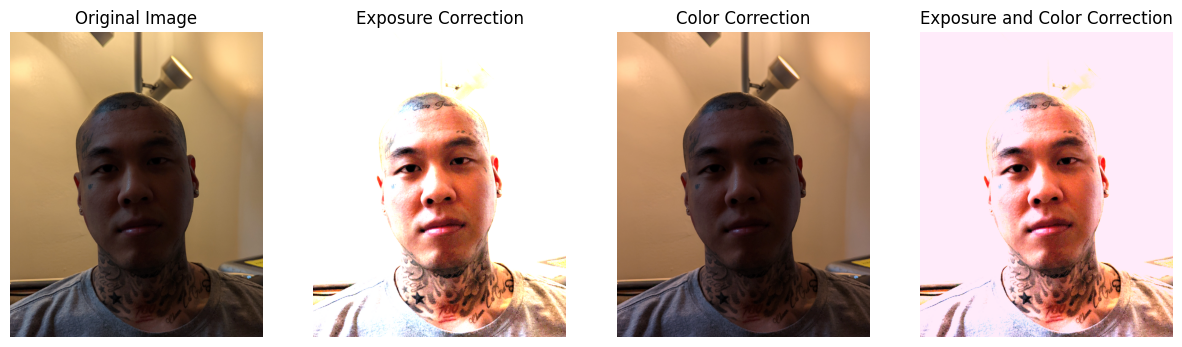

I0000 00:00:1732544339.336114   10476 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1732544339.343094   26210 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.0.9-0ubuntu0.2), renderer: Mesa Intel(R) HD Graphics 620 (KBL GT2)
W0000 00:00:1732544339.357017   26205 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1732544339.381942   26207 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


I0000 00:00:1732544344.237366   10476 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1732544344.244804   26220 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.0.9-0ubuntu0.2), renderer: Mesa Intel(R) HD Graphics 620 (KBL GT2)
W0000 00:00:1732544344.259404   26215 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1732544344.306549   26216 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


I0000 00:00:1732544350.369898   10476 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1732544350.374882   26227 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.0.9-0ubuntu0.2), renderer: Mesa Intel(R) HD Graphics 620 (KBL GT2)
W0000 00:00:1732544350.385695   26222 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1732544350.416722   26221 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


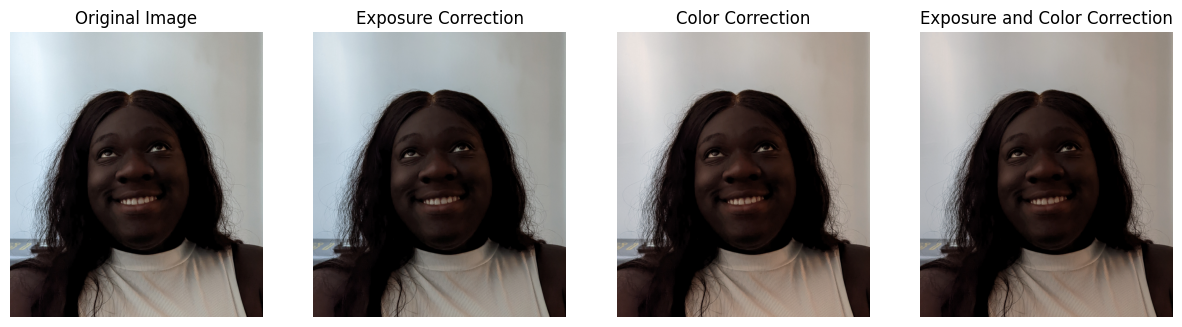

I0000 00:00:1732544355.587658   10476 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1732544355.589160   26234 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.0.9-0ubuntu0.2), renderer: Mesa Intel(R) HD Graphics 620 (KBL GT2)
W0000 00:00:1732544355.594470   26229 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1732544355.610606   26229 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


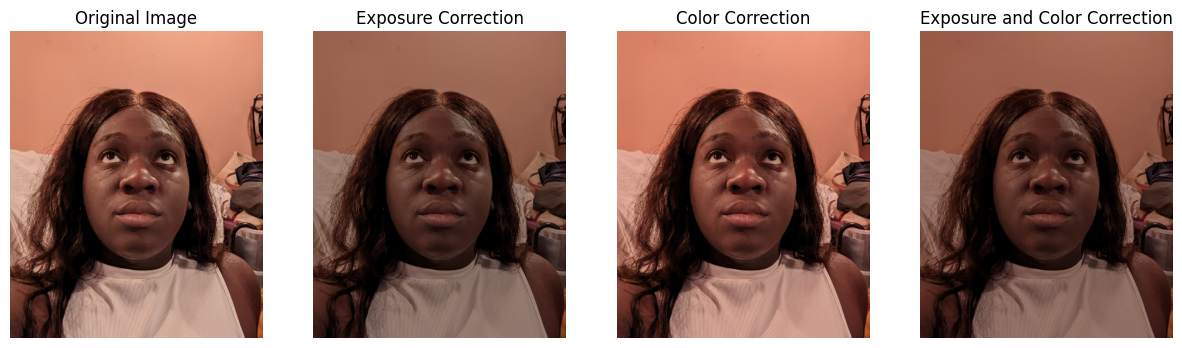

I0000 00:00:1732544361.828000   10476 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1732544361.829399   26241 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.0.9-0ubuntu0.2), renderer: Mesa Intel(R) HD Graphics 620 (KBL GT2)
W0000 00:00:1732544361.838014   26238 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1732544361.886615   26235 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


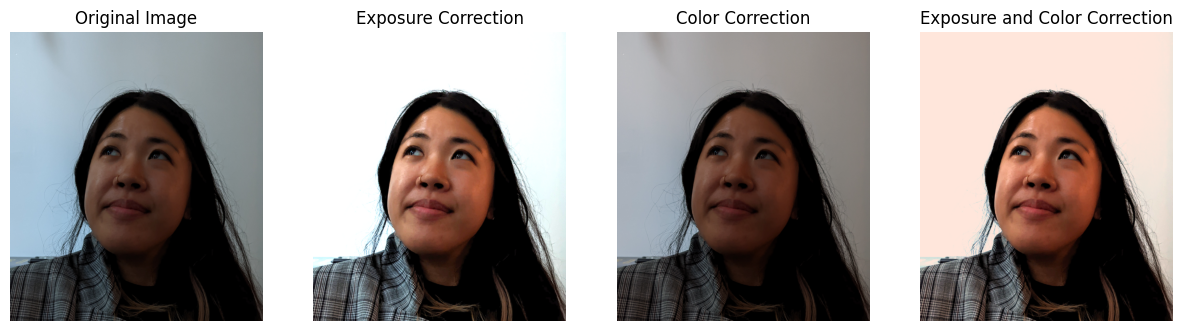

I0000 00:00:1732544366.904047   10476 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1732544366.908381   26250 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.0.9-0ubuntu0.2), renderer: Mesa Intel(R) HD Graphics 620 (KBL GT2)
W0000 00:00:1732544366.920185   26247 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1732544367.057196   26244 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


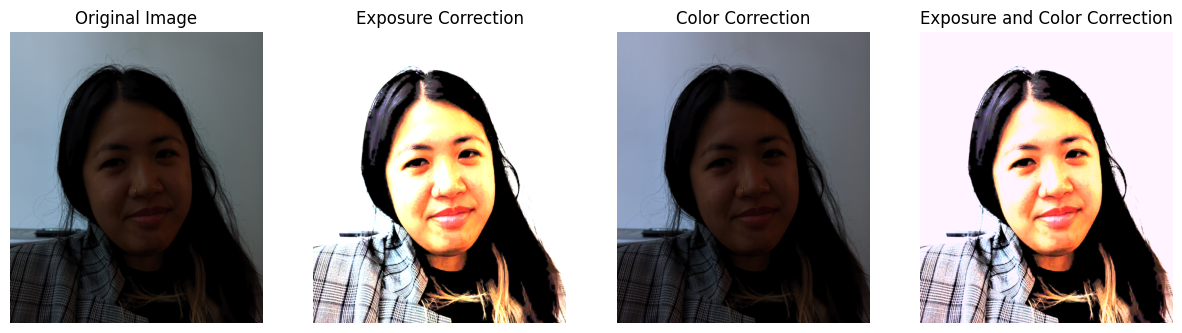

I0000 00:00:1732544372.903869   10476 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1732544372.908307   26264 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.0.9-0ubuntu0.2), renderer: Mesa Intel(R) HD Graphics 620 (KBL GT2)
W0000 00:00:1732544372.921347   26259 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1732544372.953531   26261 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


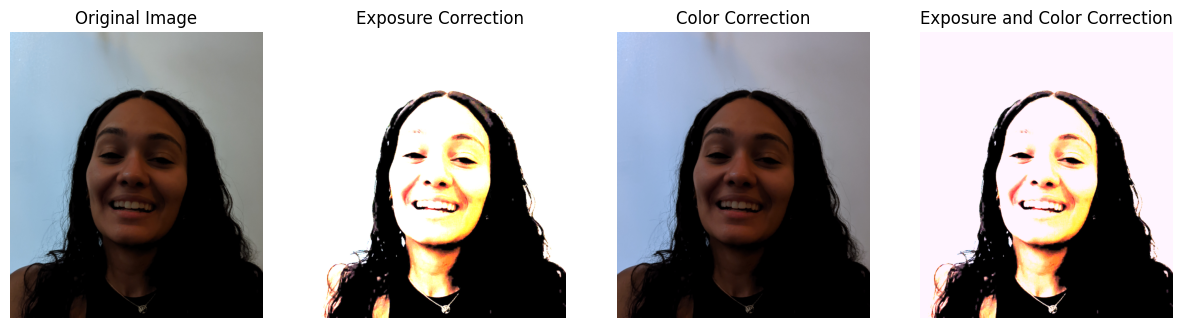

I0000 00:00:1732544378.176632   10476 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1732544378.185150   26272 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.0.9-0ubuntu0.2), renderer: Mesa Intel(R) HD Graphics 620 (KBL GT2)
W0000 00:00:1732544378.194463   26269 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1732544378.223247   26266 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


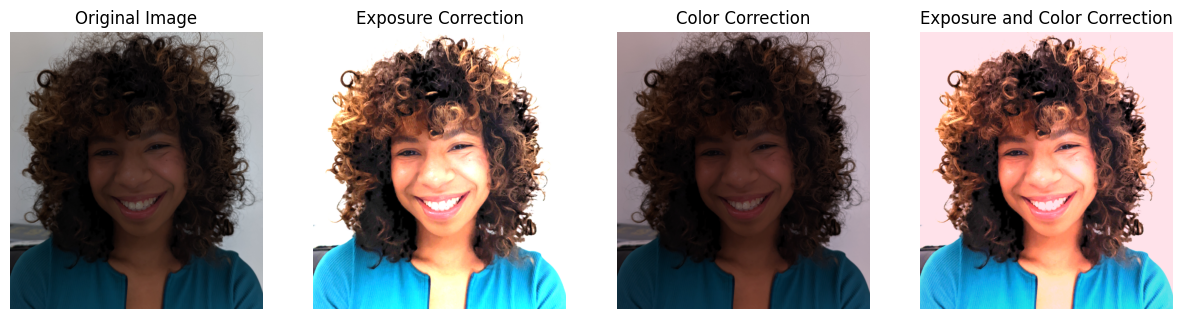

I0000 00:00:1732544385.102701   10476 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1732544385.106292   26279 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.0.9-0ubuntu0.2), renderer: Mesa Intel(R) HD Graphics 620 (KBL GT2)
W0000 00:00:1732544385.115901   26276 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1732544385.149668   26273 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


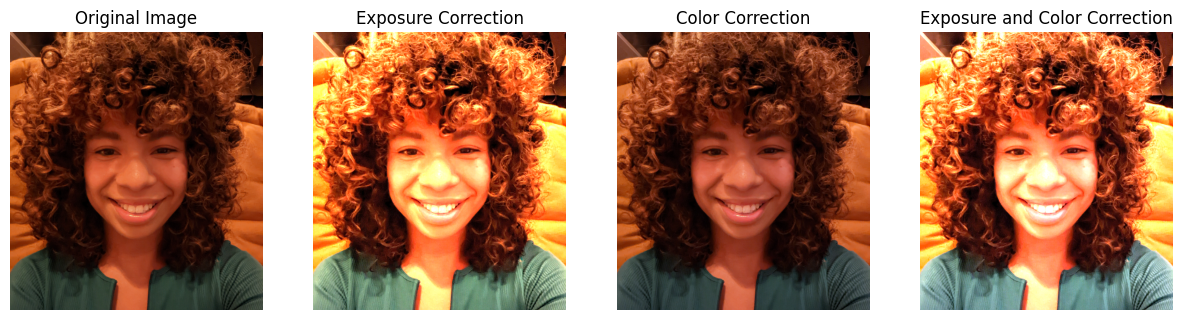

I0000 00:00:1732544394.604823   10476 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1732544394.619915   26309 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.0.9-0ubuntu0.2), renderer: Mesa Intel(R) HD Graphics 620 (KBL GT2)
W0000 00:00:1732544394.630804   26306 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1732544394.731263   26303 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


I0000 00:00:1732544403.009013   10476 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1732544403.016715   26318 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.0.9-0ubuntu0.2), renderer: Mesa Intel(R) HD Graphics 620 (KBL GT2)
W0000 00:00:1732544403.033043   26314 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1732544403.085318   26315 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


In [81]:
# Reference average sclera color in the CIE xyY color space
reference_sclera_xy = (0.369, 0.367) # NOTE: the same paper also provided this RGB value: [0.70, 0.59, 0.54]
relative_std_dev = (2.41 / 100, 2.43 / 100) 

# image_paths = baseline_utils.get_random_image_paths('/home/dasec-notebook/Thesis/Datasets/mst-e_data/mst-e_data_portrait', 15)

underexposed_image_paths = ["/home/dasec-notebook/Thesis/Datasets/mst-e_data/mst-e_data_portrait/subject_0/PXL_20220922_134006137.jpg", 
                            "/home/dasec-notebook/Thesis/Datasets/mst-e_data/mst-e_data_portrait/subject_0/PXL_20220922_134134361.jpg",
                             "/home/dasec-notebook/Thesis/Datasets/mst-e_data/mst-e_data_portrait/subject_2/PXL_20220922_173921134.jpg",
                             "/home/dasec-notebook/Thesis/Datasets/mst-e_data/mst-e_data_portrait/subject_4/PXL_20220922_162306073.jpg",
                             "/home/dasec-notebook/Thesis/Datasets/mst-e_data/mst-e_data_portrait/subject_4/PXL_20220922_162358077.jpg",
                             "/home/dasec-notebook/Thesis/Datasets/mst-e_data/mst-e_data_portrait/subject_6/PXL_20220922_142106716.jpg",
                             "/home/dasec-notebook/Thesis/Datasets/mst-e_data/mst-e_data_portrait/subject_6/PXL_20220922_142156487.jpg",
                             "/home/dasec-notebook/Thesis/Datasets/mst-e_data/mst-e_data_portrait/subject_9/PXL_20220922_135941951.jpg",
                             "/home/dasec-notebook/Thesis/Datasets/mst-e_data/mst-e_data_portrait/subject_11/PXL_20220922_194707277.jpg",
                             "/home/dasec-notebook/Thesis/Datasets/mst-e_data/mst-e_data_portrait/subject_11/PXL_20220922_194544335.jpg",
                             "/home/dasec-notebook/Thesis/Datasets/mst-e_data/mst-e_data_portrait/subject_15/PXL_20220922_131806066.jpg",
                             "/home/dasec-notebook/Thesis/Datasets/mst-e_data/mst-e_data_portrait/subject_18/PXL_20220922_183517768.jpg"

                            ]



mp_face_mesh = mp.solutions.face_mesh

for image_path in underexposed_image_paths:

    image = cv2.imread(image_path)

    if image is None:
        raise ValueError("Image not found at the specified path!")

    height, width, _ = image.shape

    l_locations, r_locations = sclera.get_sclera_location(mp_face_mesh, image_path)

    # Extract sclera pixel values
    if l_locations and r_locations:
        l_values, r_values = sclera.get_sclera_pixels(image_path, l_locations, r_locations)


    # Otsu segmentation

    if l_locations and r_locations:

        l_eye_mask = color_correction_utils.create_eye_mask_otsu(l_locations, l_values, height, width)
        r_eye_mask = color_correction_utils.create_eye_mask_otsu(r_locations, r_values, height, width)
        
        otsu_mask = cv2.bitwise_or(l_eye_mask, r_eye_mask)

    otsu_sclera_coords = np.column_stack(np.where(otsu_mask != 0))


    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    l_otsu_moving_avg_rgb = color_correction_utils.calculate_patch_avg_color(image, l_eye_mask, color_correction_utils.calculate_coords(l_eye_mask), window_size=20, stride=10)
    r_otsu_moving_avg_rgb = color_correction_utils.calculate_patch_avg_color(image, r_eye_mask, color_correction_utils.calculate_coords(r_eye_mask), window_size=20, stride=10)



    # Color correction based on sclera

    # Convert average sclera color to xyY
    l_xyY = color_correction_utils.rgb_to_xyY(l_otsu_moving_avg_rgb)
    r_xyY = color_correction_utils.rgb_to_xyY(r_otsu_moving_avg_rgb)

    # Compute the illuminant estimation for both sides (assuming symmetry)
    I_x = (l_xyY[0] + r_xyY[0]) / 2
    I_y = (l_xyY[1] + r_xyY[1]) / 2
    I_Y = (l_xyY[2] + r_xyY[2]) / 2  # Average luminance of left and right sclera

    # Normalize the reference sclera values (from canonical illuminant)
    reference_x, reference_y = reference_sclera_xy
    illuminant_ratio = (I_x / reference_x, I_y / reference_y)
    exposure_factor = reference_sclera_xy[1]  / I_Y

    image_corrected_exposure = color_correction_utils.adjust_exposure(image, exposure_factor)

    # Perform chromatic adaptation
    corrected_image = color_correction_utils.von_kries_correction(image, illuminant_ratio)

    corrected_exposure_color_image = color_correction_utils.von_kries_correction(image_corrected_exposure, illuminant_ratio)

    # Plot original and corrected images side by side
    color_correction_utils.plot_images(image, image_corrected_exposure, corrected_image, corrected_exposure_color_image)




Color and exposure correction, saves images locally

In [7]:
import os
import cv2
import numpy as np
import mediapipe as mp

# Reference average sclera color in the CIE xyY color space
reference_sclera_xy = (0.369, 0.367)  # xyY reference values
relative_std_dev = (2.41 / 100, 2.43 / 100)

# Root directory paths
# input_root_dir = '/home/dasec-notebook/Thesis/Datasets/mst-e_data/mst-e_data_portrait'
# output_root_dir = '/home/dasec-notebook/Thesis/Datasets/mst-e_data/mst-e_data_portrait_illuminant_correction/'

input_root_dir = '/home/dasec-notebook/Thesis/Datasets/CHROMA-FIT-Dataset/DATA_CROPPED_PORTRAIT2'
output_root_dir = '/home/dasec-notebook/Thesis/Datasets/CHROMA-FIT-Dataset/DATA_CROPPED_PORTRAIT2_illuminant_correction'

color_correction_folder = "color_correction"
exposure_correction_folder = "exposure_correction"
exposure_color_correction_folder = "exposure_color_correction"

mp_face_mesh = mp.solutions.face_mesh

# Walk through the input directory tree
for root, dirs, files in os.walk(input_root_dir):
    for file in files:
        if file.lower().endswith(('.jpg', '.png', '.jpeg')):  # Add more extensions if needed
            input_image_path = os.path.join(root, file)
            
            # Load image
            image = cv2.imread(input_image_path)

            if image is None:
                print(f"Warning: Could not read {input_image_path}. Skipping.")
                continue

            height, width, _ = image.shape

            # Get sclera locations
            l_locations, r_locations = sclera.get_sclera_location(mp_face_mesh, input_image_path)

            if not (l_locations and r_locations):
                print(f"Warning: Sclera locations not found in {input_image_path}. Skipping.")
                continue

            l_locations = sclera_segmentation_utils.clip_coordinates(l_locations, height, width)
            r_locations = sclera_segmentation_utils.clip_coordinates(r_locations, height, width)

            # Extract sclera pixel values
            l_values, r_values = sclera.get_sclera_pixels(input_image_path, l_locations, r_locations)

            # Perform Otsu segmentation
            l_eye_mask = color_correction_utils.create_eye_mask_otsu(l_locations, l_values, height, width)
            r_eye_mask = color_correction_utils.create_eye_mask_otsu(r_locations, r_values, height, width)
            otsu_mask = cv2.bitwise_or(l_eye_mask, r_eye_mask)

            otsu_sclera_coords = np.column_stack(np.where(otsu_mask != 0))

            # Convert to RGB for processing
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

            l_otsu_moving_avg_rgb = color_correction_utils.masked_moving_average(image, l_eye_mask, patch_size=5)
            r_otsu_moving_avg_rgb = color_correction_utils.masked_moving_average(image, r_eye_mask, patch_size=5)

            l_otsu_moving_avg_rgb = [int(round(value)) for value in l_otsu_moving_avg_rgb]
            r_otsu_moving_avg_rgb = [int(round(value)) for value in r_otsu_moving_avg_rgb]

            # Calculate average color for each eye
            # l_otsu_moving_avg_rgb = color_correction_utils.calculate_patch_avg_color(
            #     image, l_eye_mask, color_correction_utils.calculate_coords(l_eye_mask), window_size=5, stride=1
            # )
            # r_otsu_moving_avg_rgb = color_correction_utils.calculate_patch_avg_color(
            #     image, r_eye_mask, color_correction_utils.calculate_coords(r_eye_mask), window_size=5, stride=1
            # )

            # Proceed if at least one average is valid
            if l_otsu_moving_avg_rgb is not None or r_otsu_moving_avg_rgb is not None:
                # Default to the available values for calculations
                if l_otsu_moving_avg_rgb is None:
                    l_otsu_moving_avg_rgb = r_otsu_moving_avg_rgb
                    print(f"Warning: Left eye average not found in {input_image_path}. Using right eye average instead.")
                if r_otsu_moving_avg_rgb is None:
                    r_otsu_moving_avg_rgb = l_otsu_moving_avg_rgb
                    print(f"Warning: Right eye average not found in {input_image_path}. Using left eye average instead.")

                # Color correction based on sclera
                l_xyY = color_correction_utils.rgb_to_xyY(l_otsu_moving_avg_rgb)
                r_xyY = color_correction_utils.rgb_to_xyY(r_otsu_moving_avg_rgb)

                # Compute illuminant estimation
                I_x = (l_xyY[0] + r_xyY[0]) / 2
                I_y = (l_xyY[1] + r_xyY[1]) / 2
                I_Y = (l_xyY[2] + r_xyY[2]) / 2

                # Normalize reference values
                reference_x, reference_y = reference_sclera_xy
                illuminant_ratio = (I_x / reference_x, I_y / reference_y)
                exposure_factor = reference_sclera_xy[1] / I_Y

                # Correct exposure
                image_corrected_exposure = color_correction_utils.adjust_exposure(image, exposure_factor)

                # Perform chromatic adaptation
                corrected_image = color_correction_utils.von_kries_correction(image, illuminant_ratio)
                corrected_exposure_color_image = color_correction_utils.von_kries_correction(image_corrected_exposure, illuminant_ratio)

                # Save output images
                folder_name = os.path.basename(root)

                if not os.path.exists(os.path.join(output_root_dir, color_correction_folder, folder_name)):
                    os.makedirs(os.path.join(output_root_dir, color_correction_folder, folder_name))

                if not os.path.exists(os.path.join(output_root_dir, exposure_correction_folder, folder_name)):
                    os.makedirs(os.path.join(output_root_dir, exposure_correction_folder, folder_name))

                if not os.path.exists(os.path.join(output_root_dir, exposure_color_correction_folder, folder_name)):
                    os.makedirs(os.path.join(output_root_dir, exposure_color_correction_folder, folder_name))

                cv2.imwrite(os.path.join(output_root_dir, color_correction_folder, folder_name, file), cv2.cvtColor(corrected_image, cv2.COLOR_RGB2BGR))
                cv2.imwrite(os.path.join(output_root_dir, exposure_correction_folder, folder_name, file), cv2.cvtColor(image_corrected_exposure, cv2.COLOR_RGB2BGR))
                cv2.imwrite(os.path.join(output_root_dir, exposure_color_correction_folder, folder_name, file), cv2.cvtColor(corrected_exposure_color_image, cv2.COLOR_RGB2BGR))

                print(f"Processed and saved: {input_image_path}")
            
            else:
                print(f"Warning: Average sclera color not found in {input_image_path}. Skipping.")


I0000 00:00:1733401936.093896   25218 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1733401936.099432   34154 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.0.9-0ubuntu0.2), renderer: Mesa Intel(R) HD Graphics 620 (KBL GT2)
W0000 00:00:1733401936.104130   34149 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1733401936.149728   34151 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Processed and saved: /home/dasec-notebook/Thesis/Datasets/CHROMA-FIT-Dataset/DATA_CROPPED_PORTRAIT2/00080/DSC_0703.JPG


I0000 00:00:1733401936.625476   25218 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1733401936.632041   34165 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.0.9-0ubuntu0.2), renderer: Mesa Intel(R) HD Graphics 620 (KBL GT2)
W0000 00:00:1733401936.644926   34162 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1733401936.706798   34160 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Processed and saved: /home/dasec-notebook/Thesis/Datasets/CHROMA-FIT-Dataset/DATA_CROPPED_PORTRAIT2/00195/DSC_1745.JPG


I0000 00:00:1733401937.182824   25218 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1733401937.187114   34174 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.0.9-0ubuntu0.2), renderer: Mesa Intel(R) HD Graphics 620 (KBL GT2)
W0000 00:00:1733401937.210261   34171 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1733401937.275654   34170 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Processed and saved: /home/dasec-notebook/Thesis/Datasets/CHROMA-FIT-Dataset/DATA_CROPPED_PORTRAIT2/00195/DSC_4109.JPG
Processed and saved: /home/dasec-notebook/Thesis/Datasets/CHROMA-FIT-Dataset/DATA_CROPPED_PORTRAIT2/00104/DSC_1934.JPG


I0000 00:00:1733401937.441242   25218 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1733401937.448974   34181 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.0.9-0ubuntu0.2), renderer: Mesa Intel(R) HD Graphics 620 (KBL GT2)
W0000 00:00:1733401937.476502   34178 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1733401937.508960   34177 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1733401937.672062   25218 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1733401937.679332   34189 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.0.9-0ubuntu0.2), renderer: Mesa Intel(R) HD Graphics 620 (KBL GT2)
W0000 00:00:1733401937.695902   34185 inference_feedback_manager.cc:114] Feedback manager re

Processed and saved: /home/dasec-notebook/Thesis/Datasets/CHROMA-FIT-Dataset/DATA_CROPPED_PORTRAIT2/00104/DSC_0909.JPG
Processed and saved: /home/dasec-notebook/Thesis/Datasets/CHROMA-FIT-Dataset/DATA_CROPPED_PORTRAIT2/00202/DSC_1809.JPG


I0000 00:00:1733401937.989941   25218 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1733401937.991941   34196 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.0.9-0ubuntu0.2), renderer: Mesa Intel(R) HD Graphics 620 (KBL GT2)
W0000 00:00:1733401938.001535   34192 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1733401938.015450   34193 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1733401938.148485   25218 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1733401938.150162   34203 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.0.9-0ubuntu0.2), renderer: Mesa Intel(R) HD Graphics 620 (KBL GT2)
W0000 00:00:1733401938.155558   34199 inference_feedback_manager.cc:114] Feedback manager re

Processed and saved: /home/dasec-notebook/Thesis/Datasets/CHROMA-FIT-Dataset/DATA_CROPPED_PORTRAIT2/00086/DSC_0754.JPG


I0000 00:00:1733401938.202973   25218 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1733401938.204064   34210 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.0.9-0ubuntu0.2), renderer: Mesa Intel(R) HD Graphics 620 (KBL GT2)
W0000 00:00:1733401938.208605   34205 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1733401938.224292   34206 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1733401938.383143   25218 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1733401938.386367   34219 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.0.9-0ubuntu0.2), renderer: Mesa Intel(R) HD Graphics 620 (KBL GT2)
W0000 00:00:1733401938.394220   34214 inference_feedback_manager.cc:114] Feedback manager re

Processed and saved: /home/dasec-notebook/Thesis/Datasets/CHROMA-FIT-Dataset/DATA_CROPPED_PORTRAIT2/00086/DSC_1754.JPG


W0000 00:00:1733401938.412447   34214 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1733401938.465187   25218 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1733401938.466659   34226 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.0.9-0ubuntu0.2), renderer: Mesa Intel(R) HD Graphics 620 (KBL GT2)
W0000 00:00:1733401938.473258   34220 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1733401938.490731   34222 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Processed and saved: /home/dasec-notebook/Thesis/Datasets/CHROMA-FIT-Dataset/DATA_CROPPED_PORTRAIT2/00052/DSC_0457.JPG
Processed and saved: /home/dasec-notebook/Thesis/Datasets/CHROMA-FIT-Dataset/DATA_CROPPED_PORTRAIT2/00052/DSC_0893.JPG


I0000 00:00:1733401938.647449   25218 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1733401938.649521   34233 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.0.9-0ubuntu0.2), renderer: Mesa Intel(R) HD Graphics 620 (KBL GT2)
W0000 00:00:1733401938.655685   34228 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1733401938.670987   34230 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1733401938.708698   25218 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1733401938.710373   34240 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.0.9-0ubuntu0.2), renderer: Mesa Intel(R) HD Graphics 620 (KBL GT2)
W0000 00:00:1733401938.717434   34235 inference_feedback_manager.cc:114] Feedback manager re

Processed and saved: /home/dasec-notebook/Thesis/Datasets/CHROMA-FIT-Dataset/DATA_CROPPED_PORTRAIT2/00068/DSC_0602.JPG
Processed and saved: /home/dasec-notebook/Thesis/Datasets/CHROMA-FIT-Dataset/DATA_CROPPED_PORTRAIT2/00068/DSC_0603.JPG


I0000 00:00:1733401938.896667   25218 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1733401938.898432   34247 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.0.9-0ubuntu0.2), renderer: Mesa Intel(R) HD Graphics 620 (KBL GT2)
W0000 00:00:1733401938.906629   34243 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1733401938.920598   34241 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1733401939.055815   25218 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1733401939.057101   34254 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.0.9-0ubuntu0.2), renderer: Mesa Intel(R) HD Graphics 620 (KBL GT2)
W0000 00:00:1733401939.060746   34250 inference_feedback_manager.cc:114] Feedback manager re

Processed and saved: /home/dasec-notebook/Thesis/Datasets/CHROMA-FIT-Dataset/DATA_CROPPED_PORTRAIT2/00068/DSC_1431.JPG
Processed and saved: /home/dasec-notebook/Thesis/Datasets/CHROMA-FIT-Dataset/DATA_CROPPED_PORTRAIT2/00173/DSC_1537.JPG


I0000 00:00:1733401939.125499   25218 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1733401939.128267   34261 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.0.9-0ubuntu0.2), renderer: Mesa Intel(R) HD Graphics 620 (KBL GT2)
W0000 00:00:1733401939.134396   34258 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1733401939.150692   34256 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1733401939.293472   25218 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1733401939.294734   34268 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.0.9-0ubuntu0.2), renderer: Mesa Intel(R) HD Graphics 620 (KBL GT2)
W0000 00:00:1733401939.298568   34263 inference_feedback_manager.cc:114] Feedback manager re

Processed and saved: /home/dasec-notebook/Thesis/Datasets/CHROMA-FIT-Dataset/DATA_CROPPED_PORTRAIT2/00141/DSC_2736.JPG
Processed and saved: /home/dasec-notebook/Thesis/Datasets/CHROMA-FIT-Dataset/DATA_CROPPED_PORTRAIT2/00141/DSC_1246.JPG


I0000 00:00:1733401939.367067   25218 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1733401939.369734   34275 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.0.9-0ubuntu0.2), renderer: Mesa Intel(R) HD Graphics 620 (KBL GT2)
W0000 00:00:1733401939.377053   34271 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1733401939.390060   34272 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1733401939.544040   25218 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1733401939.546229   34282 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.0.9-0ubuntu0.2), renderer: Mesa Intel(R) HD Graphics 620 (KBL GT2)
W0000 00:00:1733401939.551466   34279 inference_feedback_manager.cc:114] Feedback manager re

Processed and saved: /home/dasec-notebook/Thesis/Datasets/CHROMA-FIT-Dataset/DATA_CROPPED_PORTRAIT2/00170/DSC_3409.JPG
Processed and saved: /home/dasec-notebook/Thesis/Datasets/CHROMA-FIT-Dataset/DATA_CROPPED_PORTRAIT2/00170/DSC_1510.JPG


I0000 00:00:1733401939.622470   25218 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1733401939.624728   34289 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.0.9-0ubuntu0.2), renderer: Mesa Intel(R) HD Graphics 620 (KBL GT2)
W0000 00:00:1733401939.637266   34283 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1733401939.654861   34284 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1733401939.779234   25218 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1733401939.781307   34296 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.0.9-0ubuntu0.2), renderer: Mesa Intel(R) HD Graphics 620 (KBL GT2)
W0000 00:00:1733401939.785526   34290 inference_feedback_manager.cc:114] Feedback manager re

Processed and saved: /home/dasec-notebook/Thesis/Datasets/CHROMA-FIT-Dataset/DATA_CROPPED_PORTRAIT2/00067/DSC_1341.JPG
Processed and saved: /home/dasec-notebook/Thesis/Datasets/CHROMA-FIT-Dataset/DATA_CROPPED_PORTRAIT2/00067/DSC_0593.JPG


I0000 00:00:1733401939.876603   25218 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1733401939.878224   34303 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.0.9-0ubuntu0.2), renderer: Mesa Intel(R) HD Graphics 620 (KBL GT2)
W0000 00:00:1733401939.885839   34298 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1733401939.909460   34297 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Processed and saved: /home/dasec-notebook/Thesis/Datasets/CHROMA-FIT-Dataset/DATA_CROPPED_PORTRAIT2/00001/DSC_0033.JPG


I0000 00:00:1733401940.098419   25218 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1733401940.100628   34310 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.0.9-0ubuntu0.2), renderer: Mesa Intel(R) HD Graphics 620 (KBL GT2)
W0000 00:00:1733401940.108713   34306 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1733401940.122868   34305 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1733401940.267784   25218 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1733401940.272672   34317 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.0.9-0ubuntu0.2), renderer: Mesa Intel(R) HD Graphics 620 (KBL GT2)
W0000 00:00:1733401940.278829   34311 inference_feedback_manager.cc:114] Feedback manager re

Processed and saved: /home/dasec-notebook/Thesis/Datasets/CHROMA-FIT-Dataset/DATA_CROPPED_PORTRAIT2/00024/DSC_0195.JPG
Processed and saved: /home/dasec-notebook/Thesis/Datasets/CHROMA-FIT-Dataset/DATA_CROPPED_PORTRAIT2/00092/DSC_0808.JPG
Processed and saved: /home/dasec-notebook/Thesis/Datasets/CHROMA-FIT-Dataset/DATA_CROPPED_PORTRAIT2/00092/DSC_1665.JPG


I0000 00:00:1733401940.444486   25218 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1733401940.445825   34324 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.0.9-0ubuntu0.2), renderer: Mesa Intel(R) HD Graphics 620 (KBL GT2)
W0000 00:00:1733401940.456648   34319 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1733401940.480909   34318 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1733401940.588368   25218 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1733401940.590184   34331 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.0.9-0ubuntu0.2), renderer: Mesa Intel(R) HD Graphics 620 (KBL GT2)
W0000 00:00:1733401940.595278   34327 inference_feedback_manager.cc:114] Feedback manager re

Processed and saved: /home/dasec-notebook/Thesis/Datasets/CHROMA-FIT-Dataset/DATA_CROPPED_PORTRAIT2/00061/DSC_0538.JPG


I0000 00:00:1733401940.661077   25218 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1733401940.662450   34338 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.0.9-0ubuntu0.2), renderer: Mesa Intel(R) HD Graphics 620 (KBL GT2)
W0000 00:00:1733401940.666751   34335 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1733401940.692865   34335 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1733401940.842607   25218 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1733401940.843972   34345 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.0.9-0ubuntu0.2), renderer: Mesa Intel(R) HD Graphics 620 (KBL GT2)
W0000 00:00:1733401940.848448   34340 inference_feedback_manager.cc:114] Feedback manager re

Processed and saved: /home/dasec-notebook/Thesis/Datasets/CHROMA-FIT-Dataset/DATA_CROPPED_PORTRAIT2/00007/DSC_0059.JPG


W0000 00:00:1733401940.872160   34339 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1733401940.999075   25218 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1733401941.001722   34352 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.0.9-0ubuntu0.2), renderer: Mesa Intel(R) HD Graphics 620 (KBL GT2)
W0000 00:00:1733401941.012872   34348 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1733401941.029885   34346 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Processed and saved: /home/dasec-notebook/Thesis/Datasets/CHROMA-FIT-Dataset/DATA_CROPPED_PORTRAIT2/00094/DSC_0825.JPG
Processed and saved: /home/dasec-notebook/Thesis/Datasets/CHROMA-FIT-Dataset/DATA_CROPPED_PORTRAIT2/00094/DSC_1691.JPG


I0000 00:00:1733401941.209502   25218 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1733401941.210960   34360 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.0.9-0ubuntu0.2), renderer: Mesa Intel(R) HD Graphics 620 (KBL GT2)
W0000 00:00:1733401941.224183   34356 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1733401941.241967   34354 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1733401941.287554   25218 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1733401941.289702   34367 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.0.9-0ubuntu0.2), renderer: Mesa Intel(R) HD Graphics 620 (KBL GT2)
W0000 00:00:1733401941.300185   34364 inference_feedback_manager.cc:114] Feedback manager re

Processed and saved: /home/dasec-notebook/Thesis/Datasets/CHROMA-FIT-Dataset/DATA_CROPPED_PORTRAIT2/00128/DSC_1128.JPG
Processed and saved: /home/dasec-notebook/Thesis/Datasets/CHROMA-FIT-Dataset/DATA_CROPPED_PORTRAIT2/00128/DSC_2280.JPG


I0000 00:00:1733401941.482614   25218 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1733401941.484790   34374 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.0.9-0ubuntu0.2), renderer: Mesa Intel(R) HD Graphics 620 (KBL GT2)
W0000 00:00:1733401941.491600   34371 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1733401941.507886   34369 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1733401941.547393   25218 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1733401941.549022   34381 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.0.9-0ubuntu0.2), renderer: Mesa Intel(R) HD Graphics 620 (KBL GT2)
W0000 00:00:1733401941.553411   34376 inference_feedback_manager.cc:114] Feedback manager re

Processed and saved: /home/dasec-notebook/Thesis/Datasets/CHROMA-FIT-Dataset/DATA_CROPPED_PORTRAIT2/00027/DSC_0222.JPG


I0000 00:00:1733401941.720587   25218 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1733401941.730484   34388 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.0.9-0ubuntu0.2), renderer: Mesa Intel(R) HD Graphics 620 (KBL GT2)
W0000 00:00:1733401941.736357   34382 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1733401941.761566   34384 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1733401941.798062   25218 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1733401941.799181   34395 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.0.9-0ubuntu0.2), renderer: Mesa Intel(R) HD Graphics 620 (KBL GT2)
W0000 00:00:1733401941.804498   34390 inference_feedback_manager.cc:114] Feedback manager re

Processed and saved: /home/dasec-notebook/Thesis/Datasets/CHROMA-FIT-Dataset/DATA_CROPPED_PORTRAIT2/00044/DSC_0384.JPG
Processed and saved: /home/dasec-notebook/Thesis/Datasets/CHROMA-FIT-Dataset/DATA_CROPPED_PORTRAIT2/00191/DSC_3907.JPG
Processed and saved: /home/dasec-notebook/Thesis/Datasets/CHROMA-FIT-Dataset/DATA_CROPPED_PORTRAIT2/00191/DSC_1707.JPG

I0000 00:00:1733401941.994901   25218 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1733401941.997032   34403 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.0.9-0ubuntu0.2), renderer: Mesa Intel(R) HD Graphics 620 (KBL GT2)
W0000 00:00:1733401942.004543   34398 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1733401942.018291   34399 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1733401942.064077   25218 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1733401942.065857   34410 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.0.9-0ubuntu0.2), renderer: Mesa Intel(R) HD Graphics 620 (KBL GT2)
W0000 00:00:1733401942.070654   34405 inference_feedback_manager.cc:114] Feedback manager re


Processed and saved: /home/dasec-notebook/Thesis/Datasets/CHROMA-FIT-Dataset/DATA_CROPPED_PORTRAIT2/00193/DSC_4093.JPG


I0000 00:00:1733401942.212661   25218 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1733401942.214296   34417 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.0.9-0ubuntu0.2), renderer: Mesa Intel(R) HD Graphics 620 (KBL GT2)
W0000 00:00:1733401942.220725   34413 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1733401942.242559   34412 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1733401942.283434   25218 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1733401942.284592   34424 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.0.9-0ubuntu0.2), renderer: Mesa Intel(R) HD Graphics 620 (KBL GT2)
W0000 00:00:1733401942.291015   34419 inference_feedback_manager.cc:114] Feedback manager re

Processed and saved: /home/dasec-notebook/Thesis/Datasets/CHROMA-FIT-Dataset/DATA_CROPPED_PORTRAIT2/00193/DSC_1726.JPG
Processed and saved: /home/dasec-notebook/Thesis/Datasets/CHROMA-FIT-Dataset/DATA_CROPPED_PORTRAIT2/00056/DSC_0493.JPG


I0000 00:00:1733401942.466265   25218 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1733401942.468075   34431 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.0.9-0ubuntu0.2), renderer: Mesa Intel(R) HD Graphics 620 (KBL GT2)
W0000 00:00:1733401942.477936   34426 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1733401942.492033   34427 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1733401942.641109   25218 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1733401942.642750   34439 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.0.9-0ubuntu0.2), renderer: Mesa Intel(R) HD Graphics 620 (KBL GT2)
W0000 00:00:1733401942.647392   34435 inference_feedback_manager.cc:114] Feedback manager re

I0000 00:00:1733401942.711105   25218 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1733401942.717973   34446 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.0.9-0ubuntu0.2), renderer: Mesa Intel(R) HD Graphics 620 (KBL GT2)
W0000 00:00:1733401942.733660   34441 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1733401942.780343   34441 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Processed and saved: /home/dasec-notebook/Thesis/Datasets/CHROMA-FIT-Dataset/DATA_CROPPED_PORTRAIT2/00030/DSC_0250.JPG
Processed and saved: /home/dasec-notebook/Thesis/Datasets/CHROMA-FIT-Dataset/DATA_CROPPED_PORTRAIT2/00099/DSC_0867.JPG


I0000 00:00:1733401943.209194   25218 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1733401943.210580   34453 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.0.9-0ubuntu0.2), renderer: Mesa Intel(R) HD Graphics 620 (KBL GT2)
W0000 00:00:1733401943.218561   34448 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1733401943.234170   34450 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1733401943.352719   25218 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1733401943.354142   34460 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.0.9-0ubuntu0.2), renderer: Mesa Intel(R) HD Graphics 620 (KBL GT2)
W0000 00:00:1733401943.358959   34457 inference_feedback_manager.cc:114] Feedback manager re

Processed and saved: /home/dasec-notebook/Thesis/Datasets/CHROMA-FIT-Dataset/DATA_CROPPED_PORTRAIT2/00099/DSC_1796.JPG


I0000 00:00:1733401943.451811   25218 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1733401943.454071   34467 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.0.9-0ubuntu0.2), renderer: Mesa Intel(R) HD Graphics 620 (KBL GT2)
W0000 00:00:1733401943.463762   34462 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1733401943.488381   34462 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1733401943.540134   25218 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1733401943.541181   34474 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.0.9-0ubuntu0.2), renderer: Mesa Intel(R) HD Graphics 620 (KBL GT2)
W0000 00:00:1733401943.547991   34471 inference_feedback_manager.cc:114] Feedback manager re

Processed and saved: /home/dasec-notebook/Thesis/Datasets/CHROMA-FIT-Dataset/DATA_CROPPED_PORTRAIT2/00184/DSC_1639.JPG
Processed and saved: /home/dasec-notebook/Thesis/Datasets/CHROMA-FIT-Dataset/DATA_CROPPED_PORTRAIT2/00064/DSC_0565.JPG


I0000 00:00:1733401943.696359   25218 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1733401943.698577   34481 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.0.9-0ubuntu0.2), renderer: Mesa Intel(R) HD Graphics 620 (KBL GT2)
W0000 00:00:1733401943.705506   34477 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1733401943.728113   34477 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1733401943.827803   25218 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1733401943.828971   34488 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.0.9-0ubuntu0.2), renderer: Mesa Intel(R) HD Graphics 620 (KBL GT2)
W0000 00:00:1733401943.832833   34484 inference_feedback_manager.cc:114] Feedback manager re

Processed and saved: /home/dasec-notebook/Thesis/Datasets/CHROMA-FIT-Dataset/DATA_CROPPED_PORTRAIT2/00119/DSC_1045.JPG
Processed and saved: /home/dasec-notebook/Thesis/Datasets/CHROMA-FIT-Dataset/DATA_CROPPED_PORTRAIT2/00119/DSC_2142.JPG


I0000 00:00:1733401944.074287   25218 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1733401944.079846   34495 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.0.9-0ubuntu0.2), renderer: Mesa Intel(R) HD Graphics 620 (KBL GT2)
W0000 00:00:1733401944.090244   34491 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1733401944.117372   34490 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1733401944.244915   25218 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1733401944.250490   34502 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.0.9-0ubuntu0.2), renderer: Mesa Intel(R) HD Graphics 620 (KBL GT2)
W0000 00:00:1733401944.258904   34497 inference_feedback_manager.cc:114] Feedback manager re

Processed and saved: /home/dasec-notebook/Thesis/Datasets/CHROMA-FIT-Dataset/DATA_CROPPED_PORTRAIT2/00153/DSC_2967.JPG


W0000 00:00:1733401944.294938   34498 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1733401944.407918   25218 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1733401944.412559   34509 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.0.9-0ubuntu0.2), renderer: Mesa Intel(R) HD Graphics 620 (KBL GT2)
W0000 00:00:1733401944.422498   34504 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1733401944.459738   34505 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Processed and saved: /home/dasec-notebook/Thesis/Datasets/CHROMA-FIT-Dataset/DATA_CROPPED_PORTRAIT2/00153/DSC_1353.JPG
Processed and saved: /home/dasec-notebook/Thesis/Datasets/CHROMA-FIT-Dataset/DATA_CROPPED_PORTRAIT2/00161/DSC_3175.JPG


I0000 00:00:1733401944.642536   25218 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1733401944.645033   34516 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.0.9-0ubuntu0.2), renderer: Mesa Intel(R) HD Graphics 620 (KBL GT2)
W0000 00:00:1733401944.653035   34511 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1733401944.673339   34512 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1733401944.725551   25218 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1733401944.726799   34523 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.0.9-0ubuntu0.2), renderer: Mesa Intel(R) HD Graphics 620 (KBL GT2)
W0000 00:00:1733401944.737936   34519 inference_feedback_manager.cc:114] Feedback manager re

Processed and saved: /home/dasec-notebook/Thesis/Datasets/CHROMA-FIT-Dataset/DATA_CROPPED_PORTRAIT2/00161/DSC_1425.JPG
Processed and saved: /home/dasec-notebook/Thesis/Datasets/CHROMA-FIT-Dataset/DATA_CROPPED_PORTRAIT2/00010/DSC_0077.JPG


I0000 00:00:1733401944.941317   25218 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1733401944.943426   34530 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.0.9-0ubuntu0.2), renderer: Mesa Intel(R) HD Graphics 620 (KBL GT2)
W0000 00:00:1733401944.951596   34526 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1733401944.977971   34524 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1733401945.105173   25218 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1733401945.106641   34537 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.0.9-0ubuntu0.2), renderer: Mesa Intel(R) HD Graphics 620 (KBL GT2)
W0000 00:00:1733401945.111492   34534 inference_feedback_manager.cc:114] Feedback manager re

Processed and saved: /home/dasec-notebook/Thesis/Datasets/CHROMA-FIT-Dataset/DATA_CROPPED_PORTRAIT2/00166/DSC_1476.JPG
Processed and saved: /home/dasec-notebook/Thesis/Datasets/CHROMA-FIT-Dataset/DATA_CROPPED_PORTRAIT2/00166/DSC_3215.JPG


I0000 00:00:1733401945.297222   25218 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1733401945.298596   34544 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.0.9-0ubuntu0.2), renderer: Mesa Intel(R) HD Graphics 620 (KBL GT2)
W0000 00:00:1733401945.304337   34541 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1733401945.322133   34539 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1733401945.362686   25218 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1733401945.364058   34551 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.0.9-0ubuntu0.2), renderer: Mesa Intel(R) HD Graphics 620 (KBL GT2)
W0000 00:00:1733401945.368042   34545 inference_feedback_manager.cc:114] Feedback manager re

Processed and saved: /home/dasec-notebook/Thesis/Datasets/CHROMA-FIT-Dataset/DATA_CROPPED_PORTRAIT2/00166/DSC_1473.JPG
Processed and saved: /home/dasec-notebook/Thesis/Datasets/CHROMA-FIT-Dataset/DATA_CROPPED_PORTRAIT2/00200/DSC_4293.JPG
Processed and saved: /home/dasec-notebook/Thesis/Datasets/CHROMA-FIT-Dataset/DATA_CROPPED_PORTRAIT2/00200/DSC_1791.JPG


I0000 00:00:1733401945.570076   25218 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1733401945.573059   34558 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.0.9-0ubuntu0.2), renderer: Mesa Intel(R) HD Graphics 620 (KBL GT2)
W0000 00:00:1733401945.579454   34555 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1733401945.593927   34552 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1733401945.641465   25218 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1733401945.642683   34565 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.0.9-0ubuntu0.2), renderer: Mesa Intel(R) HD Graphics 620 (KBL GT2)
W0000 00:00:1733401945.648950   34561 inference_feedback_manager.cc:114] Feedback manager re

I0000 00:00:1733401945.789989   25218 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1733401945.791485   34572 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.0.9-0ubuntu0.2), renderer: Mesa Intel(R) HD Graphics 620 (KBL GT2)
W0000 00:00:1733401945.797537   34568 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1733401945.813139   34567 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1733401945.845181   25218 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1733401945.850043   34579 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.0.9-0ubuntu0.2), renderer: Mesa Intel(R) HD Graphics 620 (KBL GT2)
W0000 00:00:1733401945.866347   34574 inference_feedback_manager.cc:114] Feedback manager re

Processed and saved: /home/dasec-notebook/Thesis/Datasets/CHROMA-FIT-Dataset/DATA_CROPPED_PORTRAIT2/00097/DSC_0850.JPG
Processed and saved: /home/dasec-notebook/Thesis/Datasets/CHROMA-FIT-Dataset/DATA_CROPPED_PORTRAIT2/00097/DSC_1756.JPG


I0000 00:00:1733401946.041050   25218 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1733401946.042389   34586 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.0.9-0ubuntu0.2), renderer: Mesa Intel(R) HD Graphics 620 (KBL GT2)
W0000 00:00:1733401946.048968   34581 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1733401946.076022   34582 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1733401946.122008   25218 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1733401946.123187   34595 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.0.9-0ubuntu0.2), renderer: Mesa Intel(R) HD Graphics 620 (KBL GT2)
W0000 00:00:1733401946.127968   34590 inference_feedback_manager.cc:114] Feedback manager re

Processed and saved: /home/dasec-notebook/Thesis/Datasets/CHROMA-FIT-Dataset/DATA_CROPPED_PORTRAIT2/00155/DSC_1371.JPG
Processed and saved: /home/dasec-notebook/Thesis/Datasets/CHROMA-FIT-Dataset/DATA_CROPPED_PORTRAIT2/00192/DSC_1717.JPG


I0000 00:00:1733401946.317719   25218 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1733401946.321768   34602 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.0.9-0ubuntu0.2), renderer: Mesa Intel(R) HD Graphics 620 (KBL GT2)
W0000 00:00:1733401946.331246   34598 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1733401946.350115   34599 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1733401946.380209   25218 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1733401946.381587   34609 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.0.9-0ubuntu0.2), renderer: Mesa Intel(R) HD Graphics 620 (KBL GT2)
W0000 00:00:1733401946.386439   34604 inference_feedback_manager.cc:114] Feedback manager re

Processed and saved: /home/dasec-notebook/Thesis/Datasets/CHROMA-FIT-Dataset/DATA_CROPPED_PORTRAIT2/00192/DSC_4189.JPG


I0000 00:00:1733401946.542665   25218 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1733401946.547314   34616 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.0.9-0ubuntu0.2), renderer: Mesa Intel(R) HD Graphics 620 (KBL GT2)
W0000 00:00:1733401946.553787   34611 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1733401946.567170   34613 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1733401946.610361   25218 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1733401946.611591   34623 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.0.9-0ubuntu0.2), renderer: Mesa Intel(R) HD Graphics 620 (KBL GT2)
W0000 00:00:1733401946.617195   34618 inference_feedback_manager.cc:114] Feedback manager re

Processed and saved: /home/dasec-notebook/Thesis/Datasets/CHROMA-FIT-Dataset/DATA_CROPPED_PORTRAIT2/00189/DSC_1688.JPG
Processed and saved: /home/dasec-notebook/Thesis/Datasets/CHROMA-FIT-Dataset/DATA_CROPPED_PORTRAIT2/00058/DSC_0511.JPG


I0000 00:00:1733401946.839807   25218 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1733401946.840953   34638 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.0.9-0ubuntu0.2), renderer: Mesa Intel(R) HD Graphics 620 (KBL GT2)
W0000 00:00:1733401946.847959   34634 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1733401946.876412   34635 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1733401947.013052   25218 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1733401947.014295   34645 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.0.9-0ubuntu0.2), renderer: Mesa Intel(R) HD Graphics 620 (KBL GT2)
W0000 00:00:1733401947.020550   34640 inference_feedback_manager.cc:114] Feedback manager re

Processed and saved: /home/dasec-notebook/Thesis/Datasets/CHROMA-FIT-Dataset/DATA_CROPPED_PORTRAIT2/00124/DSC_1091.JPG


I0000 00:00:1733401947.069659   25218 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1733401947.071122   34652 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.0.9-0ubuntu0.2), renderer: Mesa Intel(R) HD Graphics 620 (KBL GT2)
W0000 00:00:1733401947.075024   34646 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1733401947.095903   34648 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1733401947.225689   25218 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1733401947.227330   34659 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.0.9-0ubuntu0.2), renderer: Mesa Intel(R) HD Graphics 620 (KBL GT2)
W0000 00:00:1733401947.231385   34654 inference_feedback_manager.cc:114] Feedback manager re

Processed and saved: /home/dasec-notebook/Thesis/Datasets/CHROMA-FIT-Dataset/DATA_CROPPED_PORTRAIT2/00183/DSC_1630.JPG
Processed and saved: /home/dasec-notebook/Thesis/Datasets/CHROMA-FIT-Dataset/DATA_CROPPED_PORTRAIT2/00079/DSC_1857.JPG


I0000 00:00:1733401947.376133   25218 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1733401947.377505   34666 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.0.9-0ubuntu0.2), renderer: Mesa Intel(R) HD Graphics 620 (KBL GT2)
W0000 00:00:1733401947.381817   34663 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1733401947.404270   34660 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1733401947.444136   25218 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1733401947.445938   34673 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.0.9-0ubuntu0.2), renderer: Mesa Intel(R) HD Graphics 620 (KBL GT2)
W0000 00:00:1733401947.450872   34668 inference_feedback_manager.cc:114] Feedback manager re

Processed and saved: /home/dasec-notebook/Thesis/Datasets/CHROMA-FIT-Dataset/DATA_CROPPED_PORTRAIT2/00079/DSC_0695.JPG
Processed and saved: /home/dasec-notebook/Thesis/Datasets/CHROMA-FIT-Dataset/DATA_CROPPED_PORTRAIT2/00075/DSC_1525.JPG


I0000 00:00:1733401947.630431   25218 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1733401947.631657   34681 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.0.9-0ubuntu0.2), renderer: Mesa Intel(R) HD Graphics 620 (KBL GT2)
W0000 00:00:1733401947.637302   34677 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1733401947.654676   34678 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1733401947.750053   25218 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1733401947.754739   34688 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.0.9-0ubuntu0.2), renderer: Mesa Intel(R) HD Graphics 620 (KBL GT2)
W0000 00:00:1733401947.763059   34683 inference_feedback_manager.cc:114] Feedback manager re

Processed and saved: /home/dasec-notebook/Thesis/Datasets/CHROMA-FIT-Dataset/DATA_CROPPED_PORTRAIT2/00075/DSC_0663.JPG
Processed and saved: /home/dasec-notebook/Thesis/Datasets/CHROMA-FIT-Dataset/DATA_CROPPED_PORTRAIT2/00142/DSC_2744.JPG


I0000 00:00:1733401948.078888   25218 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1733401948.080320   34695 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.0.9-0ubuntu0.2), renderer: Mesa Intel(R) HD Graphics 620 (KBL GT2)
W0000 00:00:1733401948.086522   34691 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1733401948.102238   34692 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1733401948.144663   25218 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1733401948.145861   34702 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.0.9-0ubuntu0.2), renderer: Mesa Intel(R) HD Graphics 620 (KBL GT2)
W0000 00:00:1733401948.150092   34697 inference_feedback_manager.cc:114] Feedback manager re

Processed and saved: /home/dasec-notebook/Thesis/Datasets/CHROMA-FIT-Dataset/DATA_CROPPED_PORTRAIT2/00142/DSC_1254.JPG
Processed and saved: /home/dasec-notebook/Thesis/Datasets/CHROMA-FIT-Dataset/DATA_CROPPED_PORTRAIT2/00129/DSC_1137.JPG
Processed and saved: /home/dasec-notebook/Thesis/Datasets/CHROMA-FIT-Dataset/DATA_CROPPED_PORTRAIT2/00129/DSC_2288.JPG


I0000 00:00:1733401948.345514   25218 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1733401948.347937   34710 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.0.9-0ubuntu0.2), renderer: Mesa Intel(R) HD Graphics 620 (KBL GT2)
W0000 00:00:1733401948.357319   34706 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1733401948.373922   34704 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1733401948.483360   25218 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1733401948.485121   34717 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.0.9-0ubuntu0.2), renderer: Mesa Intel(R) HD Graphics 620 (KBL GT2)
W0000 00:00:1733401948.491210   34713 inference_feedback_manager.cc:114] Feedback manager re

Processed and saved: /home/dasec-notebook/Thesis/Datasets/CHROMA-FIT-Dataset/DATA_CROPPED_PORTRAIT2/00063/DSC_0556.JPG


W0000 00:00:1733401948.566841   34718 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1733401948.723743   25218 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1733401948.727332   34731 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.0.9-0ubuntu0.2), renderer: Mesa Intel(R) HD Graphics 620 (KBL GT2)
W0000 00:00:1733401948.733521   34727 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1733401948.750351   34728 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Processed and saved: /home/dasec-notebook/Thesis/Datasets/CHROMA-FIT-Dataset/DATA_CROPPED_PORTRAIT2/00157/DSC_3000.JPG
Processed and saved: /home/dasec-notebook/Thesis/Datasets/CHROMA-FIT-Dataset/DATA_CROPPED_PORTRAIT2/00157/DSC_1389.JPG


I0000 00:00:1733401948.807414   25218 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1733401948.810363   34738 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.0.9-0ubuntu0.2), renderer: Mesa Intel(R) HD Graphics 620 (KBL GT2)
W0000 00:00:1733401948.820640   34734 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1733401948.835055   34735 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1733401949.018299   25218 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1733401949.020037   34745 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.0.9-0ubuntu0.2), renderer: Mesa Intel(R) HD Graphics 620 (KBL GT2)


Processed and saved: /home/dasec-notebook/Thesis/Datasets/CHROMA-FIT-Dataset/DATA_CROPPED_PORTRAIT2/00165/DSC_1464.JPG


W0000 00:00:1733401949.024388   34739 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1733401949.044609   34742 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1733401949.207678   25218 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1733401949.211358   34752 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.0.9-0ubuntu0.2), renderer: Mesa Intel(R) HD Graphics 620 (KBL GT2)
W0000 00:00:1733401949.217664   34747 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


W0000 00:00:1733401949.235678   34748 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1733401949.278311   25218 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1733401949.280337   34759 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.0.9-0ubuntu0.2), renderer: Mesa Intel(R) HD Graphics 620 (KBL GT2)
W0000 00:00:1733401949.287569   34755 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1733401949.304667   34753 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Processed and saved: /home/dasec-notebook/Thesis/Datasets/CHROMA-FIT-Dataset/DATA_CROPPED_PORTRAIT2/00175/DSC_1556.JPG
Processed and saved: /home/dasec-notebook/Thesis/Datasets/CHROMA-FIT-Dataset/DATA_CROPPED_PORTRAIT2/00130/DSC_2296.JPG


I0000 00:00:1733401949.490853   25218 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1733401949.493175   34766 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.0.9-0ubuntu0.2), renderer: Mesa Intel(R) HD Graphics 620 (KBL GT2)
W0000 00:00:1733401949.503609   34760 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1733401949.529239   34763 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1733401949.605111   25218 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1733401949.606736   34773 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.0.9-0ubuntu0.2), renderer: Mesa Intel(R) HD Graphics 620 (KBL GT2)
W0000 00:00:1733401949.613756   34768 inference_feedback_manager.cc:114] Feedback manager re

Processed and saved: /home/dasec-notebook/Thesis/Datasets/CHROMA-FIT-Dataset/DATA_CROPPED_PORTRAIT2/00130/DSC_1146.JPG
Processed and saved: /home/dasec-notebook/Thesis/Datasets/CHROMA-FIT-Dataset/DATA_CROPPED_PORTRAIT2/00055/DSC_0918.JPG


I0000 00:00:1733401949.794483   25218 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1733401949.796063   34780 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.0.9-0ubuntu0.2), renderer: Mesa Intel(R) HD Graphics 620 (KBL GT2)
W0000 00:00:1733401949.804360   34775 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1733401949.823421   34774 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1733401949.864392   25218 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1733401949.868155   34787 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.0.9-0ubuntu0.2), renderer: Mesa Intel(R) HD Graphics 620 (KBL GT2)
W0000 00:00:1733401949.880602   34783 inference_feedback_manager.cc:114] Feedback manager re

Processed and saved: /home/dasec-notebook/Thesis/Datasets/CHROMA-FIT-Dataset/DATA_CROPPED_PORTRAIT2/00055/DSC_0484.JPG


I0000 00:00:1733401950.068197   25218 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1733401950.071807   34794 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.0.9-0ubuntu0.2), renderer: Mesa Intel(R) HD Graphics 620 (KBL GT2)
W0000 00:00:1733401950.080322   34788 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1733401950.102634   34791 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Processed and saved: /home/dasec-notebook/Thesis/Datasets/CHROMA-FIT-Dataset/DATA_CROPPED_PORTRAIT2/00126/DSC_1109.JPG
Processed and saved: /home/dasec-notebook/Thesis/Datasets/CHROMA-FIT-Dataset/DATA_CROPPED_PORTRAIT2/00126/DSC_2264.JPG


I0000 00:00:1733401950.375073   25218 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1733401950.382657   34801 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.0.9-0ubuntu0.2), renderer: Mesa Intel(R) HD Graphics 620 (KBL GT2)
W0000 00:00:1733401950.397244   34796 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1733401950.426151   34797 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1733401950.515797   25218 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1733401950.517151   34808 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.0.9-0ubuntu0.2), renderer: Mesa Intel(R) HD Graphics 620 (KBL GT2)
W0000 00:00:1733401950.523178   34803 inference_feedback_manager.cc:114] Feedback manager re

Processed and saved: /home/dasec-notebook/Thesis/Datasets/CHROMA-FIT-Dataset/DATA_CROPPED_PORTRAIT2/00012/DSC_0094.JPG
Processed and saved: /home/dasec-notebook/Thesis/Datasets/CHROMA-FIT-Dataset/DATA_CROPPED_PORTRAIT2/00032/DSC_0268.JPG


I0000 00:00:1733401950.664511   25218 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1733401950.669364   34815 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.0.9-0ubuntu0.2), renderer: Mesa Intel(R) HD Graphics 620 (KBL GT2)
W0000 00:00:1733401950.677579   34810 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1733401950.696612   34812 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1733401950.859908   25218 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1733401950.861631   34822 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.0.9-0ubuntu0.2), renderer: Mesa Intel(R) HD Graphics 620 (KBL GT2)
W0000 00:00:1733401950.866837   34817 inference_feedback_manager.cc:114] Feedback manager re

Processed and saved: /home/dasec-notebook/Thesis/Datasets/CHROMA-FIT-Dataset/DATA_CROPPED_PORTRAIT2/00149/DSC_1317.JPG


W0000 00:00:1733401950.894015   34816 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1733401950.999250   25218 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1733401951.001173   34830 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.0.9-0ubuntu0.2), renderer: Mesa Intel(R) HD Graphics 620 (KBL GT2)
W0000 00:00:1733401951.010851   34826 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1733401951.028817   34827 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1733401951.065844   25218 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1733401951.067106   34837 gl_context.cc:357] GL version: 3.2 

Processed and saved: /home/dasec-notebook/Thesis/Datasets/CHROMA-FIT-Dataset/DATA_CROPPED_PORTRAIT2/00054/DSC_0475.JPG
Processed and saved: /home/dasec-notebook/Thesis/Datasets/CHROMA-FIT-Dataset/DATA_CROPPED_PORTRAIT2/00054/DSC_0910.JPG
Processed and saved: /home/dasec-notebook/Thesis/Datasets/CHROMA-FIT-Dataset/DATA_CROPPED_PORTRAIT2/00020/DSC_0160.JPG


I0000 00:00:1733401951.261324   25218 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1733401951.262786   34844 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.0.9-0ubuntu0.2), renderer: Mesa Intel(R) HD Graphics 620 (KBL GT2)
W0000 00:00:1733401951.270514   34839 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1733401951.293817   34840 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1733401951.338282   25218 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1733401951.339995   34851 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.0.9-0ubuntu0.2), renderer: Mesa Intel(R) HD Graphics 620 (KBL GT2)
W0000 00:00:1733401951.345477   34846 inference_feedback_manager.cc:114] Feedback manager re

Processed and saved: /home/dasec-notebook/Thesis/Datasets/CHROMA-FIT-Dataset/DATA_CROPPED_PORTRAIT2/00112/DSC_0979.JPG


I0000 00:00:1733401951.474287   34858 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.0.9-0ubuntu0.2), renderer: Mesa Intel(R) HD Graphics 620 (KBL GT2)
W0000 00:00:1733401951.478914   34853 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1733401951.498819   34855 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1733401951.658676   25218 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1733401951.660686   34865 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.0.9-0ubuntu0.2), renderer: Mesa Intel(R) HD Graphics 620 (KBL GT2)
W0000 00:00:1733401951.672743   34860 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Processed and saved: /home/dasec-notebook/Thesis/Datasets/CHROMA-FIT-Dataset/DATA_CROPPED_PORTRAIT2/00174/DSC_1546.JPG
Processed and saved: /home/dasec-notebook/Thesis/Datasets/CHROMA-FIT-Dataset/DATA_CROPPED_PORTRAIT2/00041/DSC_0754.JPG


W0000 00:00:1733401951.691567   34861 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1733401951.824560   25218 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1733401951.826533   34873 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.0.9-0ubuntu0.2), renderer: Mesa Intel(R) HD Graphics 620 (KBL GT2)
W0000 00:00:1733401951.834158   34868 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1733401951.849488   34870 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Processed and saved: /home/dasec-notebook/Thesis/Datasets/CHROMA-FIT-Dataset/DATA_CROPPED_PORTRAIT2/00041/DSC_0357.JPG


I0000 00:00:1733401951.904093   25218 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1733401951.905949   34880 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.0.9-0ubuntu0.2), renderer: Mesa Intel(R) HD Graphics 620 (KBL GT2)
W0000 00:00:1733401951.910812   34874 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1733401951.932065   34874 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1733401952.088072   25218 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1733401952.089652   34887 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.0.9-0ubuntu0.2), renderer: Mesa Intel(R) HD Graphics 620 (KBL GT2)
W0000 00:00:1733401952.096913   34881 inference_feedback_manager.cc:114] Feedback manager re

Processed and saved: /home/dasec-notebook/Thesis/Datasets/CHROMA-FIT-Dataset/DATA_CROPPED_PORTRAIT2/00180/DSC_1603.JPG


W0000 00:00:1733401952.114211   34882 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1733401952.262482   25218 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1733401952.265815   34894 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.0.9-0ubuntu0.2), renderer: Mesa Intel(R) HD Graphics 620 (KBL GT2)
W0000 00:00:1733401952.275355   34888 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1733401952.290739   34891 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Processed and saved: /home/dasec-notebook/Thesis/Datasets/CHROMA-FIT-Dataset/DATA_CROPPED_PORTRAIT2/00051/DSC_0448.JPG
Processed and saved: /home/dasec-notebook/Thesis/Datasets/CHROMA-FIT-Dataset/DATA_CROPPED_PORTRAIT2/00051/DSC_0740.JPG


I0000 00:00:1733401952.459131   25218 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1733401952.467738   34902 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.0.9-0ubuntu0.2), renderer: Mesa Intel(R) HD Graphics 620 (KBL GT2)
W0000 00:00:1733401952.475096   34897 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1733401952.512730   34896 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1733401952.618023   25218 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1733401952.622779   34909 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.0.9-0ubuntu0.2), renderer: Mesa Intel(R) HD Graphics 620 (KBL GT2)
W0000 00:00:1733401952.631349   34904 inference_feedback_manager.cc:114] Feedback manager re

Processed and saved: /home/dasec-notebook/Thesis/Datasets/CHROMA-FIT-Dataset/DATA_CROPPED_PORTRAIT2/00181/DSC_1612.JPG
Processed and saved: /home/dasec-notebook/Thesis/Datasets/CHROMA-FIT-Dataset/DATA_CROPPED_PORTRAIT2/00198/DSC_1772.JPG


I0000 00:00:1733401952.867468   25218 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1733401952.868846   34916 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.0.9-0ubuntu0.2), renderer: Mesa Intel(R) HD Graphics 620 (KBL GT2)
W0000 00:00:1733401952.881132   34913 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1733401952.911150   34912 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1733401953.041484   25218 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1733401953.043126   34923 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.0.9-0ubuntu0.2), renderer: Mesa Intel(R) HD Graphics 620 (KBL GT2)
W0000 00:00:1733401953.048611   34918 inference_feedback_manager.cc:114] Feedback manager re

Processed and saved: /home/dasec-notebook/Thesis/Datasets/CHROMA-FIT-Dataset/DATA_CROPPED_PORTRAIT2/00198/DSC_4133.JPG
Processed and saved: /home/dasec-notebook/Thesis/Datasets/CHROMA-FIT-Dataset/DATA_CROPPED_PORTRAIT2/00057/DSC_0502.JPG


I0000 00:00:1733401953.127456   25218 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1733401953.132806   34931 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.0.9-0ubuntu0.2), renderer: Mesa Intel(R) HD Graphics 620 (KBL GT2)
W0000 00:00:1733401953.142414   34927 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1733401953.166687   34926 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1733401953.333291   25218 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1733401953.335036   34938 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.0.9-0ubuntu0.2), renderer: Mesa Intel(R) HD Graphics 620 (KBL GT2)


Processed and saved: /home/dasec-notebook/Thesis/Datasets/CHROMA-FIT-Dataset/DATA_CROPPED_PORTRAIT2/00106/DSC_0926.JPG


W0000 00:00:1733401953.341753   34934 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1733401953.360218   34935 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1733401953.503308   25218 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1733401953.504611   34945 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.0.9-0ubuntu0.2), renderer: Mesa Intel(R) HD Graphics 620 (KBL GT2)
W0000 00:00:1733401953.511353   34942 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1733401953.528983   34940 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Processed and saved: /home/dasec-notebook/Thesis/Datasets/CHROMA-FIT-Dataset/DATA_CROPPED_PORTRAIT2/00209/DSC_1872.JPG
Processed and saved: /home/dasec-notebook/Thesis/Datasets/CHROMA-FIT-Dataset/DATA_CROPPED_PORTRAIT2/00121/DSC_1063.JPG


I0000 00:00:1733401953.640736   25218 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1733401953.641893   34952 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.0.9-0ubuntu0.2), renderer: Mesa Intel(R) HD Graphics 620 (KBL GT2)
W0000 00:00:1733401953.648222   34948 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1733401953.667371   34947 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1733401953.697845   25218 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1733401953.698907   34959 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.0.9-0ubuntu0.2), renderer: Mesa Intel(R) HD Graphics 620 (KBL GT2)
W0000 00:00:1733401953.702827   34956 inference_feedback_manager.cc:114] Feedback manager re

Processed and saved: /home/dasec-notebook/Thesis/Datasets/CHROMA-FIT-Dataset/DATA_CROPPED_PORTRAIT2/00121/DSC_2158.JPG
Processed and saved: /home/dasec-notebook/Thesis/Datasets/CHROMA-FIT-Dataset/DATA_CROPPED_PORTRAIT2/00148/DSC_2796.JPG


I0000 00:00:1733401953.849156   25218 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1733401953.850583   34966 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.0.9-0ubuntu0.2), renderer: Mesa Intel(R) HD Graphics 620 (KBL GT2)
W0000 00:00:1733401953.854751   34963 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1733401953.870425   34962 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1733401953.939361   25218 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1733401953.943834   34973 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.0.9-0ubuntu0.2), renderer: Mesa Intel(R) HD Graphics 620 (KBL GT2)
W0000 00:00:1733401953.947888   34970 inference_feedback_manager.cc:114] Feedback manager re

Processed and saved: /home/dasec-notebook/Thesis/Datasets/CHROMA-FIT-Dataset/DATA_CROPPED_PORTRAIT2/00148/DSC_1308.JPG
Processed and saved: /home/dasec-notebook/Thesis/Datasets/CHROMA-FIT-Dataset/DATA_CROPPED_PORTRAIT2/00169/DSC_3393.JPG


I0000 00:00:1733401954.152691   25218 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1733401954.157751   34987 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.0.9-0ubuntu0.2), renderer: Mesa Intel(R) HD Graphics 620 (KBL GT2)
W0000 00:00:1733401954.164391   34982 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1733401954.178953   34981 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1733401954.219580   25218 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1733401954.220899   34994 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.0.9-0ubuntu0.2), renderer: Mesa Intel(R) HD Graphics 620 (KBL GT2)
W0000 00:00:1733401954.225391   34990 inference_feedback_manager.cc:114] Feedback manager re

Processed and saved: /home/dasec-notebook/Thesis/Datasets/CHROMA-FIT-Dataset/DATA_CROPPED_PORTRAIT2/00133/DSC_1175.JPG
Processed and saved: /home/dasec-notebook/Thesis/Datasets/CHROMA-FIT-Dataset/DATA_CROPPED_PORTRAIT2/00133/DSC_2627.JPG


I0000 00:00:1733401954.435563   25218 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1733401954.437530   35001 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.0.9-0ubuntu0.2), renderer: Mesa Intel(R) HD Graphics 620 (KBL GT2)
W0000 00:00:1733401954.445568   34996 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1733401954.472851   34998 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1733401954.607544   25218 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1733401954.613712   35008 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.0.9-0ubuntu0.2), renderer: Mesa Intel(R) HD Graphics 620 (KBL GT2)
W0000 00:00:1733401954.620167   35003 inference_feedback_manager.cc:114] Feedback manager re

Processed and saved: /home/dasec-notebook/Thesis/Datasets/CHROMA-FIT-Dataset/DATA_CROPPED_PORTRAIT2/00102/DSC_1918.JPG


W0000 00:00:1733401954.657335   35002 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1733401954.767136   25218 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1733401954.768637   35015 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.0.9-0ubuntu0.2), renderer: Mesa Intel(R) HD Graphics 620 (KBL GT2)
W0000 00:00:1733401954.782633   35010 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1733401954.801914   35012 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Processed and saved: /home/dasec-notebook/Thesis/Datasets/CHROMA-FIT-Dataset/DATA_CROPPED_PORTRAIT2/00102/DSC_0894.JPG
Processed and saved: /home/dasec-notebook/Thesis/Datasets/CHROMA-FIT-Dataset/DATA_CROPPED_PORTRAIT2/00093/DSC_1717.JPG
Processed and saved: /home/dasec-notebook/Thesis/Datasets/CHROMA-FIT-Dataset/DATA_CROPPED_PORTRAIT2/00093/DSC_0817.JPG


I0000 00:00:1733401954.944296   25218 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1733401954.945778   35022 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.0.9-0ubuntu0.2), renderer: Mesa Intel(R) HD Graphics 620 (KBL GT2)
W0000 00:00:1733401954.953148   35017 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1733401954.966385   35018 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1733401955.003044   25218 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1733401955.004342   35029 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.0.9-0ubuntu0.2), renderer: Mesa Intel(R) HD Graphics 620 (KBL GT2)
W0000 00:00:1733401955.011846   35025 inference_feedback_manager.cc:114] Feedback manager re

Processed and saved: /home/dasec-notebook/Thesis/Datasets/CHROMA-FIT-Dataset/DATA_CROPPED_PORTRAIT2/00084/DSC_0736.JPG


W0000 00:00:1733401955.167458   35030 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1733401955.313679   25218 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1733401955.314925   35043 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.0.9-0ubuntu0.2), renderer: Mesa Intel(R) HD Graphics 620 (KBL GT2)
W0000 00:00:1733401955.322484   35039 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1733401955.340968   35039 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Processed and saved: /home/dasec-notebook/Thesis/Datasets/CHROMA-FIT-Dataset/DATA_CROPPED_PORTRAIT2/00084/DSC_1572.JPG
Processed and saved: /home/dasec-notebook/Thesis/Datasets/CHROMA-FIT-Dataset/DATA_CROPPED_PORTRAIT2/00146/DSC_1289.JPG
Processed and saved: /home/dasec-notebook/Thesis/Datasets/CHROMA-FIT-Dataset/DATA_CROPPED_PORTRAIT2/00146/DSC_2776.JPG


I0000 00:00:1733401955.401019   25218 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1733401955.402712   35050 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.0.9-0ubuntu0.2), renderer: Mesa Intel(R) HD Graphics 620 (KBL GT2)
W0000 00:00:1733401955.411553   35046 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1733401955.428041   35045 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1733401955.552933   25218 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1733401955.554230   35057 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.0.9-0ubuntu0.2), renderer: Mesa Intel(R) HD Graphics 620 (KBL GT2)
W0000 00:00:1733401955.559970   35052 inference_feedback_manager.cc:114] Feedback manager re

Processed and saved: /home/dasec-notebook/Thesis/Datasets/CHROMA-FIT-Dataset/DATA_CROPPED_PORTRAIT2/00035/DSC_0300.JPG


I0000 00:00:1733401955.610970   25218 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1733401955.612457   35064 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.0.9-0ubuntu0.2), renderer: Mesa Intel(R) HD Graphics 620 (KBL GT2)
W0000 00:00:1733401955.621030   35060 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1733401955.638882   35061 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1733401955.787388   25218 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1733401955.788564   35071 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.0.9-0ubuntu0.2), renderer: Mesa Intel(R) HD Graphics 620 (KBL GT2)
W0000 00:00:1733401955.796048   35065 inference_feedback_manager.cc:114] Feedback manager re

Processed and saved: /home/dasec-notebook/Thesis/Datasets/CHROMA-FIT-Dataset/DATA_CROPPED_PORTRAIT2/00035/DSC_0704.JPG
Processed and saved: /home/dasec-notebook/Thesis/Datasets/CHROMA-FIT-Dataset/DATA_CROPPED_PORTRAIT2/00132/DSC_2619.JPG
Processed and saved: /home/dasec-notebook/Thesis/Datasets/CHROMA-FIT-Dataset/DATA_CROPPED_PORTRAIT2/00132/DSC_1166.JPG


I0000 00:00:1733401955.862859   25218 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1733401955.864122   35078 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.0.9-0ubuntu0.2), renderer: Mesa Intel(R) HD Graphics 620 (KBL GT2)
W0000 00:00:1733401955.869477   35074 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1733401955.894552   35073 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1733401955.944996   25218 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1733401955.946263   35085 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.0.9-0ubuntu0.2), renderer: Mesa Intel(R) HD Graphics 620 (KBL GT2)
W0000 00:00:1733401955.951712   35079 inference_feedback_manager.cc:114] Feedback manager re

Processed and saved: /home/dasec-notebook/Thesis/Datasets/CHROMA-FIT-Dataset/DATA_CROPPED_PORTRAIT2/00101/DSC_1910.JPG
Processed and saved: /home/dasec-notebook/Thesis/Datasets/CHROMA-FIT-Dataset/DATA_CROPPED_PORTRAIT2/00101/DSC_0884.JPG


W0000 00:00:1733401956.071270   35089 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1733401956.119886   25218 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1733401956.123267   35099 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.0.9-0ubuntu0.2), renderer: Mesa Intel(R) HD Graphics 620 (KBL GT2)
W0000 00:00:1733401956.132039   35095 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1733401956.145635   35095 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1733401956.259904   25218 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1733401956.261109   35106 gl_context.cc:357] GL version: 3.2 

Processed and saved: /home/dasec-notebook/Thesis/Datasets/CHROMA-FIT-Dataset/DATA_CROPPED_PORTRAIT2/00070/DSC_0621.JPG
Processed and saved: /home/dasec-notebook/Thesis/Datasets/CHROMA-FIT-Dataset/DATA_CROPPED_PORTRAIT2/00070/DSC_1449.JPG


W0000 00:00:1733401956.283670   35102 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1733401956.408453   25218 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1733401956.409947   35113 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.0.9-0ubuntu0.2), renderer: Mesa Intel(R) HD Graphics 620 (KBL GT2)
W0000 00:00:1733401956.419037   35107 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1733401956.434657   35109 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1733401956.474832   25218 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1733401956.476979   35120 gl_context.cc:357] GL version: 3.2 

Processed and saved: /home/dasec-notebook/Thesis/Datasets/CHROMA-FIT-Dataset/DATA_CROPPED_PORTRAIT2/00139/DSC_1230.JPG
Processed and saved: /home/dasec-notebook/Thesis/Datasets/CHROMA-FIT-Dataset/DATA_CROPPED_PORTRAIT2/00139/DSC_2675.JPG


W0000 00:00:1733401956.500873   35117 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1733401956.629224   25218 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1733401956.632946   35127 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.0.9-0ubuntu0.2), renderer: Mesa Intel(R) HD Graphics 620 (KBL GT2)
W0000 00:00:1733401956.639574   35121 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1733401956.652202   35122 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1733401956.694526   25218 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1733401956.695912   35134 gl_context.cc:357] GL version: 3.2 

Processed and saved: /home/dasec-notebook/Thesis/Datasets/CHROMA-FIT-Dataset/DATA_CROPPED_PORTRAIT2/00204/DSC_1827.JPG
Processed and saved: /home/dasec-notebook/Thesis/Datasets/CHROMA-FIT-Dataset/DATA_CROPPED_PORTRAIT2/00204/DSC_4449.JPG


I0000 00:00:1733401957.023106   25218 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1733401957.024632   35141 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.0.9-0ubuntu0.2), renderer: Mesa Intel(R) HD Graphics 620 (KBL GT2)
W0000 00:00:1733401957.033469   35137 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1733401957.067150   35138 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1733401957.131304   25218 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1733401957.132721   35148 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.0.9-0ubuntu0.2), renderer: Mesa Intel(R) HD Graphics 620 (KBL GT2)
W0000 00:00:1733401957.137206   35145 inference_feedback_manager.cc:114] Feedback manager re

Processed and saved: /home/dasec-notebook/Thesis/Datasets/CHROMA-FIT-Dataset/DATA_CROPPED_PORTRAIT2/00009/DSC_0069.JPG
Processed and saved: /home/dasec-notebook/Thesis/Datasets/CHROMA-FIT-Dataset/DATA_CROPPED_PORTRAIT2/00135/DSC_1193.JPG
Processed and saved: /home/dasec-notebook/Thesis/Datasets/CHROMA-FIT-Dataset/DATA_CROPPED_PORTRAIT2/00135/DSC_2643.JPG


I0000 00:00:1733401957.311788   25218 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1733401957.315155   35155 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.0.9-0ubuntu0.2), renderer: Mesa Intel(R) HD Graphics 620 (KBL GT2)
W0000 00:00:1733401957.320178   35151 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1733401957.338457   35152 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1733401957.459995   25218 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1733401957.461437   35162 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.0.9-0ubuntu0.2), renderer: Mesa Intel(R) HD Graphics 620 (KBL GT2)
W0000 00:00:1733401957.465767   35157 inference_feedback_manager.cc:114] Feedback manager re

Processed and saved: /home/dasec-notebook/Thesis/Datasets/CHROMA-FIT-Dataset/DATA_CROPPED_PORTRAIT2/00151/DSC_2951.JPG


I0000 00:00:1733401957.533436   25218 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1733401957.535000   35169 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.0.9-0ubuntu0.2), renderer: Mesa Intel(R) HD Graphics 620 (KBL GT2)
W0000 00:00:1733401957.540201   35164 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1733401957.558391   35163 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1733401957.601499   25218 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1733401957.602683   35176 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.0.9-0ubuntu0.2), renderer: Mesa Intel(R) HD Graphics 620 (KBL GT2)
W0000 00:00:1733401957.610576   35171 inference_feedback_manager.cc:114] Feedback manager re

Processed and saved: /home/dasec-notebook/Thesis/Datasets/CHROMA-FIT-Dataset/DATA_CROPPED_PORTRAIT2/00151/DSC_1336.JPG


I0000 00:00:1733401957.804426   25218 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1733401957.806171   35183 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.0.9-0ubuntu0.2), renderer: Mesa Intel(R) HD Graphics 620 (KBL GT2)
W0000 00:00:1733401957.815860   35180 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1733401957.835959   35177 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Processed and saved: /home/dasec-notebook/Thesis/Datasets/CHROMA-FIT-Dataset/DATA_CROPPED_PORTRAIT2/00205/DSC_1836.JPG
Processed and saved: /home/dasec-notebook/Thesis/Datasets/CHROMA-FIT-Dataset/DATA_CROPPED_PORTRAIT2/00031/DSC_0259.JPG


I0000 00:00:1733401958.045420   25218 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1733401958.052858   35190 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.0.9-0ubuntu0.2), renderer: Mesa Intel(R) HD Graphics 620 (KBL GT2)
W0000 00:00:1733401958.061688   35185 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1733401958.084255   35185 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1733401958.115867   25218 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1733401958.117063   35197 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.0.9-0ubuntu0.2), renderer: Mesa Intel(R) HD Graphics 620 (KBL GT2)
W0000 00:00:1733401958.121493   35192 inference_feedback_manager.cc:114] Feedback manager re

Processed and saved: /home/dasec-notebook/Thesis/Datasets/CHROMA-FIT-Dataset/DATA_CROPPED_PORTRAIT2/00199/DSC_1781.JPG


W0000 00:00:1733401958.264028   35199 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1733401958.280164   35200 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1733401958.311414   25218 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1733401958.312562   35211 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.0.9-0ubuntu0.2), renderer: Mesa Intel(R) HD Graphics 620 (KBL GT2)
W0000 00:00:1733401958.318929   35206 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1733401958.339721   35207 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Processed and saved: /home/dasec-notebook/Thesis/Datasets/CHROMA-FIT-Dataset/DATA_CROPPED_PORTRAIT2/00050/DSC_0732.JPG


I0000 00:00:1733401958.475839   25218 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1733401958.477452   35218 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.0.9-0ubuntu0.2), renderer: Mesa Intel(R) HD Graphics 620 (KBL GT2)
W0000 00:00:1733401958.484355   35213 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1733401958.502874   35212 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1733401958.560624   25218 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1733401958.564988   35225 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.0.9-0ubuntu0.2), renderer: Mesa Intel(R) HD Graphics 620 (KBL GT2)
W0000 00:00:1733401958.575883   35220 inference_feedback_manager.cc:114] Feedback manager re

Processed and saved: /home/dasec-notebook/Thesis/Datasets/CHROMA-FIT-Dataset/DATA_CROPPED_PORTRAIT2/00050/DSC_0440.JPG


I0000 00:00:1733401958.747443   25218 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1733401958.749590   35232 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.0.9-0ubuntu0.2), renderer: Mesa Intel(R) HD Graphics 620 (KBL GT2)
W0000 00:00:1733401958.759969   35228 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1733401958.803113   35227 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Processed and saved: /home/dasec-notebook/Thesis/Datasets/CHROMA-FIT-Dataset/DATA_CROPPED_PORTRAIT2/00003/DSC_0042.JPG


I0000 00:00:1733401959.011132   25218 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1733401959.012920   35239 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.0.9-0ubuntu0.2), renderer: Mesa Intel(R) HD Graphics 620 (KBL GT2)
W0000 00:00:1733401959.022382   35234 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1733401959.056465   35233 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Processed and saved: /home/dasec-notebook/Thesis/Datasets/CHROMA-FIT-Dataset/DATA_CROPPED_PORTRAIT2/00196/DSC_1754.JPG


I0000 00:00:1733401959.284704   25218 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1733401959.288835   35246 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.0.9-0ubuntu0.2), renderer: Mesa Intel(R) HD Graphics 620 (KBL GT2)
W0000 00:00:1733401959.295243   35241 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1733401959.316310   35240 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1733401959.345883   25218 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1733401959.347376   35253 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.0.9-0ubuntu0.2), renderer: Mesa Intel(R) HD Graphics 620 (KBL GT2)
W0000 00:00:1733401959.351639   35248 inference_feedback_manager.cc:114] Feedback manager re

Processed and saved: /home/dasec-notebook/Thesis/Datasets/CHROMA-FIT-Dataset/DATA_CROPPED_PORTRAIT2/00123/DSC_1081.JPG
Processed and saved: /home/dasec-notebook/Thesis/Datasets/CHROMA-FIT-Dataset/DATA_CROPPED_PORTRAIT2/00117/DSC_1027.JPG


I0000 00:00:1733401959.558552   25218 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1733401959.560353   35260 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.0.9-0ubuntu0.2), renderer: Mesa Intel(R) HD Graphics 620 (KBL GT2)
W0000 00:00:1733401959.574044   35256 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1733401959.603428   35255 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1733401959.751091   25218 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1733401959.753035   35267 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.0.9-0ubuntu0.2), renderer: Mesa Intel(R) HD Graphics 620 (KBL GT2)
W0000 00:00:1733401959.759518   35264 inference_feedback_manager.cc:114] Feedback manager re

W0000 00:00:1733401959.773450   35262 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1733401959.814503   25218 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1733401959.816231   35274 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.0.9-0ubuntu0.2), renderer: Mesa Intel(R) HD Graphics 620 (KBL GT2)
W0000 00:00:1733401959.822938   35270 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1733401959.842892   35270 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Processed and saved: /home/dasec-notebook/Thesis/Datasets/CHROMA-FIT-Dataset/DATA_CROPPED_PORTRAIT2/00131/DSC_1155.JPG
Processed and saved: /home/dasec-notebook/Thesis/Datasets/CHROMA-FIT-Dataset/DATA_CROPPED_PORTRAIT2/00131/DSC_2305.JPG


I0000 00:00:1733401960.050329   25218 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1733401960.052749   35281 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.0.9-0ubuntu0.2), renderer: Mesa Intel(R) HD Graphics 620 (KBL GT2)
W0000 00:00:1733401960.059524   35277 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1733401960.080032   35275 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1733401960.129388   25218 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1733401960.130625   35288 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.0.9-0ubuntu0.2), renderer: Mesa Intel(R) HD Graphics 620 (KBL GT2)
W0000 00:00:1733401960.135443   35282 inference_feedback_manager.cc:114] Feedback manager re

Processed and saved: /home/dasec-notebook/Thesis/Datasets/CHROMA-FIT-Dataset/DATA_CROPPED_PORTRAIT2/00138/DSC_1221.JPG
Processed and saved: /home/dasec-notebook/Thesis/Datasets/CHROMA-FIT-Dataset/DATA_CROPPED_PORTRAIT2/00138/DSC_2667.JPG


I0000 00:00:1733401960.290791   25218 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1733401960.292991   35295 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.0.9-0ubuntu0.2), renderer: Mesa Intel(R) HD Graphics 620 (KBL GT2)
W0000 00:00:1733401960.301380   35289 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1733401960.321771   35291 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1733401960.373776   25218 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1733401960.375180   35302 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.0.9-0ubuntu0.2), renderer: Mesa Intel(R) HD Graphics 620 (KBL GT2)
W0000 00:00:1733401960.382139   35299 inference_feedback_manager.cc:114] Feedback manager re

Processed and saved: /home/dasec-notebook/Thesis/Datasets/CHROMA-FIT-Dataset/DATA_CROPPED_PORTRAIT2/00178/DSC_1584.JPG
Processed and saved: /home/dasec-notebook/Thesis/Datasets/CHROMA-FIT-Dataset/DATA_CROPPED_PORTRAIT2/00005/DSC_0051.JPG


I0000 00:00:1733401960.561134   25218 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1733401960.563159   35309 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.0.9-0ubuntu0.2), renderer: Mesa Intel(R) HD Graphics 620 (KBL GT2)
W0000 00:00:1733401960.572229   35305 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1733401960.590012   35304 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1733401960.715121   25218 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1733401960.716295   35316 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.0.9-0ubuntu0.2), renderer: Mesa Intel(R) HD Graphics 620 (KBL GT2)
W0000 00:00:1733401960.720263   35313 inference_feedback_manager.cc:114] Feedback manager re

Processed and saved: /home/dasec-notebook/Thesis/Datasets/CHROMA-FIT-Dataset/DATA_CROPPED_PORTRAIT2/00034/DSC_0289.JPG
Processed and saved: /home/dasec-notebook/Thesis/Datasets/CHROMA-FIT-Dataset/DATA_CROPPED_PORTRAIT2/00168/DSC_1491.JPG


I0000 00:00:1733401960.879309   25218 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1733401960.883348   35325 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.0.9-0ubuntu0.2), renderer: Mesa Intel(R) HD Graphics 620 (KBL GT2)
W0000 00:00:1733401960.889611   35320 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1733401960.914699   35321 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1733401961.040530   25218 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1733401961.042123   35332 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.0.9-0ubuntu0.2), renderer: Mesa Intel(R) HD Graphics 620 (KBL GT2)
W0000 00:00:1733401961.048349   35327 inference_feedback_manager.cc:114] Feedback manager re

Processed and saved: /home/dasec-notebook/Thesis/Datasets/CHROMA-FIT-Dataset/DATA_CROPPED_PORTRAIT2/00083/DSC_0727.JPG
Processed and saved: /home/dasec-notebook/Thesis/Datasets/CHROMA-FIT-Dataset/DATA_CROPPED_PORTRAIT2/00122/DSC_2166.JPG


I0000 00:00:1733401961.250125   25218 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1733401961.252936   35339 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.0.9-0ubuntu0.2), renderer: Mesa Intel(R) HD Graphics 620 (KBL GT2)
W0000 00:00:1733401961.261523   35334 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1733401961.278271   35336 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1733401961.330659   25218 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1733401961.331790   35346 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.0.9-0ubuntu0.2), renderer: Mesa Intel(R) HD Graphics 620 (KBL GT2)
W0000 00:00:1733401961.337255   35342 inference_feedback_manager.cc:114] Feedback manager re

Processed and saved: /home/dasec-notebook/Thesis/Datasets/CHROMA-FIT-Dataset/DATA_CROPPED_PORTRAIT2/00060/DSC_0529.JPG
Processed and saved: /home/dasec-notebook/Thesis/Datasets/CHROMA-FIT-Dataset/DATA_CROPPED_PORTRAIT2/00071/DSC_1458.JPG


I0000 00:00:1733401961.674373   25218 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1733401961.685261   35353 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.0.9-0ubuntu0.2), renderer: Mesa Intel(R) HD Graphics 620 (KBL GT2)
W0000 00:00:1733401961.697068   35348 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1733401961.734286   35349 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1733401961.816043   25218 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1733401961.817671   35360 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.0.9-0ubuntu0.2), renderer: Mesa Intel(R) HD Graphics 620 (KBL GT2)
W0000 00:00:1733401961.830082   35356 inference_feedback_manager.cc:114] Feedback manager re

Processed and saved: /home/dasec-notebook/Thesis/Datasets/CHROMA-FIT-Dataset/DATA_CROPPED_PORTRAIT2/00071/DSC_0630.JPG
Processed and saved: /home/dasec-notebook/Thesis/Datasets/CHROMA-FIT-Dataset/DATA_CROPPED_PORTRAIT2/00158/DSC_3008.JPG


I0000 00:00:1733401962.011273   25218 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1733401962.016053   35367 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.0.9-0ubuntu0.2), renderer: Mesa Intel(R) HD Graphics 620 (KBL GT2)
W0000 00:00:1733401962.023705   35364 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1733401962.039038   35362 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1733401962.082641   25218 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1733401962.083792   35374 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.0.9-0ubuntu0.2), renderer: Mesa Intel(R) HD Graphics 620 (KBL GT2)
W0000 00:00:1733401962.088690   35368 inference_feedback_manager.cc:114] Feedback manager re

Processed and saved: /home/dasec-notebook/Thesis/Datasets/CHROMA-FIT-Dataset/DATA_CROPPED_PORTRAIT2/00158/DSC_1398.JPG
Processed and saved: /home/dasec-notebook/Thesis/Datasets/CHROMA-FIT-Dataset/DATA_CROPPED_PORTRAIT2/00015/DSC_0118.JPG


I0000 00:00:1733401962.237887   25218 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1733401962.243124   35381 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.0.9-0ubuntu0.2), renderer: Mesa Intel(R) HD Graphics 620 (KBL GT2)
W0000 00:00:1733401962.248496   35378 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1733401962.271242   35377 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1733401962.406426   25218 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1733401962.410590   35388 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.0.9-0ubuntu0.2), renderer: Mesa Intel(R) HD Graphics 620 (KBL GT2)
W0000 00:00:1733401962.421295   35385 inference_feedback_manager.cc:114] Feedback manager re

Processed and saved: /home/dasec-notebook/Thesis/Datasets/CHROMA-FIT-Dataset/DATA_CROPPED_PORTRAIT2/00021/DSC_0168.JPG
Processed and saved: /home/dasec-notebook/Thesis/Datasets/CHROMA-FIT-Dataset/DATA_CROPPED_PORTRAIT2/00013/DSC_0102.JPG


I0000 00:00:1733401962.605378   25218 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1733401962.607066   35395 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.0.9-0ubuntu0.2), renderer: Mesa Intel(R) HD Graphics 620 (KBL GT2)
W0000 00:00:1733401962.618214   35391 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1733401962.636805   35392 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1733401962.780730   25218 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1733401962.782361   35402 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.0.9-0ubuntu0.2), renderer: Mesa Intel(R) HD Graphics 620 (KBL GT2)
W0000 00:00:1733401962.789102   35396 inference_feedback_manager.cc:114] Feedback manager re

Processed and saved: /home/dasec-notebook/Thesis/Datasets/CHROMA-FIT-Dataset/DATA_CROPPED_PORTRAIT2/00013/DSC_0101.JPG
Processed and saved: /home/dasec-notebook/Thesis/Datasets/CHROMA-FIT-Dataset/DATA_CROPPED_PORTRAIT2/00163/DSC_3191.JPG


I0000 00:00:1733401962.968635   25218 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1733401962.970957   35409 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.0.9-0ubuntu0.2), renderer: Mesa Intel(R) HD Graphics 620 (KBL GT2)
W0000 00:00:1733401962.978736   35406 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1733401962.999117   35405 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1733401963.043765   25218 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1733401963.045335   35416 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.0.9-0ubuntu0.2), renderer: Mesa Intel(R) HD Graphics 620 (KBL GT2)
W0000 00:00:1733401963.050237   35412 inference_feedback_manager.cc:114] Feedback manager re

Processed and saved: /home/dasec-notebook/Thesis/Datasets/CHROMA-FIT-Dataset/DATA_CROPPED_PORTRAIT2/00163/DSC_1445.JPG
Processed and saved: /home/dasec-notebook/Thesis/Datasets/CHROMA-FIT-Dataset/DATA_CROPPED_PORTRAIT2/00073/DSC_0647.JPG


I0000 00:00:1733401963.208131   25218 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1733401963.211543   35423 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.0.9-0ubuntu0.2), renderer: Mesa Intel(R) HD Graphics 620 (KBL GT2)
W0000 00:00:1733401963.219631   35417 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1733401963.248269   35419 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Processed and saved: /home/dasec-notebook/Thesis/Datasets/CHROMA-FIT-Dataset/DATA_CROPPED_PORTRAIT2/00073/DSC_1507.JPG


I0000 00:00:1733401963.438509   25218 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1733401963.440243   35430 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.0.9-0ubuntu0.2), renderer: Mesa Intel(R) HD Graphics 620 (KBL GT2)
W0000 00:00:1733401963.446829   35425 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1733401963.476981   35426 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1733401963.541118   25218 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1733401963.542923   35437 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.0.9-0ubuntu0.2), renderer: Mesa Intel(R) HD Graphics 620 (KBL GT2)
W0000 00:00:1733401963.549204   35431 inference_feedback_manager.cc:114] Feedback manager re

Processed and saved: /home/dasec-notebook/Thesis/Datasets/CHROMA-FIT-Dataset/DATA_CROPPED_PORTRAIT2/00046/DSC_0401.JPG
Processed and saved: /home/dasec-notebook/Thesis/Datasets/CHROMA-FIT-Dataset/DATA_CROPPED_PORTRAIT2/00046/DSC_0700.JPG


I0000 00:00:1733401963.841350   25218 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1733401963.849555   35444 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.0.9-0ubuntu0.2), renderer: Mesa Intel(R) HD Graphics 620 (KBL GT2)
W0000 00:00:1733401963.862284   35440 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1733401963.944049   35439 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1733401964.063675   25218 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1733401964.068821   35451 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.0.9-0ubuntu0.2), renderer: Mesa Intel(R) HD Graphics 620 (KBL GT2)
W0000 00:00:1733401964.080920   35447 inference_feedback_manager.cc:114] Feedback manager re

Processed and saved: /home/dasec-notebook/Thesis/Datasets/CHROMA-FIT-Dataset/DATA_CROPPED_PORTRAIT2/00134/DSC_1184.JPG
Processed and saved: /home/dasec-notebook/Thesis/Datasets/CHROMA-FIT-Dataset/DATA_CROPPED_PORTRAIT2/00134/DSC_2635.JPG


I0000 00:00:1733401964.292142   25218 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1733401964.296079   35458 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.0.9-0ubuntu0.2), renderer: Mesa Intel(R) HD Graphics 620 (KBL GT2)
W0000 00:00:1733401964.303684   35455 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1733401964.318096   35452 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1733401964.362221   25218 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1733401964.363499   35465 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.0.9-0ubuntu0.2), renderer: Mesa Intel(R) HD Graphics 620 (KBL GT2)
W0000 00:00:1733401964.370496   35461 inference_feedback_manager.cc:114] Feedback manager re

Processed and saved: /home/dasec-notebook/Thesis/Datasets/CHROMA-FIT-Dataset/DATA_CROPPED_PORTRAIT2/00206/DSC_1845.JPG
Processed and saved: /home/dasec-notebook/Thesis/Datasets/CHROMA-FIT-Dataset/DATA_CROPPED_PORTRAIT2/00206/DSC_4465.JPG


I0000 00:00:1733401964.529564   25218 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1733401964.534450   35472 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.0.9-0ubuntu0.2), renderer: Mesa Intel(R) HD Graphics 620 (KBL GT2)
W0000 00:00:1733401964.542381   35467 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1733401964.556800   35466 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1733401964.595445   25218 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1733401964.596850   35479 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.0.9-0ubuntu0.2), renderer: Mesa Intel(R) HD Graphics 620 (KBL GT2)
W0000 00:00:1733401964.602051   35474 inference_feedback_manager.cc:114] Feedback manager re

Processed and saved: /home/dasec-notebook/Thesis/Datasets/CHROMA-FIT-Dataset/DATA_CROPPED_PORTRAIT2/00143/DSC_1262.JPG
Processed and saved: /home/dasec-notebook/Thesis/Datasets/CHROMA-FIT-Dataset/DATA_CROPPED_PORTRAIT2/00143/DSC_2752.JPG
Processed and saved: /home/dasec-notebook/Thesis/Datasets/CHROMA-FIT-Dataset/DATA_CROPPED_PORTRAIT2/00152/DSC_2959.JPG


I0000 00:00:1733401964.797760   25218 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1733401964.804359   35486 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.0.9-0ubuntu0.2), renderer: Mesa Intel(R) HD Graphics 620 (KBL GT2)
W0000 00:00:1733401964.811373   35480 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1733401964.835261   35483 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1733401964.875544   25218 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1733401964.876937   35493 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.0.9-0ubuntu0.2), renderer: Mesa Intel(R) HD Graphics 620 (KBL GT2)
W0000 00:00:1733401964.882664   35489 inference_feedback_manager.cc:114] Feedback manager re

Processed and saved: /home/dasec-notebook/Thesis/Datasets/CHROMA-FIT-Dataset/DATA_CROPPED_PORTRAIT2/00059/DSC_0520.JPG
Processed and saved: /home/dasec-notebook/Thesis/Datasets/CHROMA-FIT-Dataset/DATA_CROPPED_PORTRAIT2/00207/DSC_4341.JPG


I0000 00:00:1733401965.182588   25218 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1733401965.184077   35507 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.0.9-0ubuntu0.2), renderer: Mesa Intel(R) HD Graphics 620 (KBL GT2)
W0000 00:00:1733401965.194066   35502 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1733401965.212679   35501 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1733401965.262786   25218 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1733401965.264195   35514 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.0.9-0ubuntu0.2), renderer: Mesa Intel(R) HD Graphics 620 (KBL GT2)
W0000 00:00:1733401965.270760   35510 inference_feedback_manager.cc:114] Feedback manager re

Processed and saved: /home/dasec-notebook/Thesis/Datasets/CHROMA-FIT-Dataset/DATA_CROPPED_PORTRAIT2/00037/DSC_0319.JPG
Processed and saved: /home/dasec-notebook/Thesis/Datasets/CHROMA-FIT-Dataset/DATA_CROPPED_PORTRAIT2/00037/DSC_0721.JPG
Processed and saved: /home/dasec-notebook/Thesis/Datasets/CHROMA-FIT-Dataset/DATA_CROPPED_PORTRAIT2/00105/DSC_0918.JPG


I0000 00:00:1733401965.441776   25218 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1733401965.444617   35521 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.0.9-0ubuntu0.2), renderer: Mesa Intel(R) HD Graphics 620 (KBL GT2)
W0000 00:00:1733401965.451614   35515 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1733401965.475320   35516 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1733401965.521580   25218 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1733401965.523013   35528 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.0.9-0ubuntu0.2), renderer: Mesa Intel(R) HD Graphics 620 (KBL GT2)
W0000 00:00:1733401965.528731   35522 inference_feedback_manager.cc:114] Feedback manager re

Processed and saved: /home/dasec-notebook/Thesis/Datasets/CHROMA-FIT-Dataset/DATA_CROPPED_PORTRAIT2/00053/DSC_0901.JPG


I0000 00:00:1733401965.651077   25218 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1733401965.652288   35535 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.0.9-0ubuntu0.2), renderer: Mesa Intel(R) HD Graphics 620 (KBL GT2)
W0000 00:00:1733401965.657996   35530 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1733401965.672327   35530 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1733401965.731793   25218 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1733401965.733425   35546 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.0.9-0ubuntu0.2), renderer: Mesa Intel(R) HD Graphics 620 (KBL GT2)
W0000 00:00:1733401965.741847   35543 inference_feedback_manager.cc:114] Feedback manager re

Processed and saved: /home/dasec-notebook/Thesis/Datasets/CHROMA-FIT-Dataset/DATA_CROPPED_PORTRAIT2/00053/DSC_0466.JPG
Processed and saved: /home/dasec-notebook/Thesis/Datasets/CHROMA-FIT-Dataset/DATA_CROPPED_PORTRAIT2/00042/DSC_0762.JPG


I0000 00:00:1733401965.892335   25218 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1733401965.893905   35553 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.0.9-0ubuntu0.2), renderer: Mesa Intel(R) HD Graphics 620 (KBL GT2)
W0000 00:00:1733401965.903640   35548 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1733401965.931735   35550 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1733401966.035331   25218 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1733401966.042491   35560 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.0.9-0ubuntu0.2), renderer: Mesa Intel(R) HD Graphics 620 (KBL GT2)
W0000 00:00:1733401966.050983   35557 inference_feedback_manager.cc:114] Feedback manager re

Processed and saved: /home/dasec-notebook/Thesis/Datasets/CHROMA-FIT-Dataset/DATA_CROPPED_PORTRAIT2/00042/DSC_0366.JPG
Processed and saved: /home/dasec-notebook/Thesis/Datasets/CHROMA-FIT-Dataset/DATA_CROPPED_PORTRAIT2/00110/DSC_0961.JPG


I0000 00:00:1733401966.315929   25218 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1733401966.317264   35567 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.0.9-0ubuntu0.2), renderer: Mesa Intel(R) HD Graphics 620 (KBL GT2)
W0000 00:00:1733401966.326444   35563 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1733401966.348970   35561 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1733401966.510575   25218 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1733401966.512661   35575 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.0.9-0ubuntu0.2), renderer: Mesa Intel(R) HD Graphics 620 (KBL GT2)
W0000 00:00:1733401966.518775   35569 inference_feedback_manager.cc:114] Feedback manager re

Processed and saved: /home/dasec-notebook/Thesis/Datasets/CHROMA-FIT-Dataset/DATA_CROPPED_PORTRAIT2/00049/DSC_0430.JPG


W0000 00:00:1733401966.546134   35572 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1733401966.689181   25218 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1733401966.691112   35582 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.0.9-0ubuntu0.2), renderer: Mesa Intel(R) HD Graphics 620 (KBL GT2)
W0000 00:00:1733401966.702343   35578 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1733401966.728346   35576 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Processed and saved: /home/dasec-notebook/Thesis/Datasets/CHROMA-FIT-Dataset/DATA_CROPPED_PORTRAIT2/00127/DSC_2272.JPG


I0000 00:00:1733401966.771333   25218 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1733401966.781116   35589 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.0.9-0ubuntu0.2), renderer: Mesa Intel(R) HD Graphics 620 (KBL GT2)
W0000 00:00:1733401966.791696   35584 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1733401966.821958   35585 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1733401966.865347   25218 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1733401966.866967   35596 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.0.9-0ubuntu0.2), renderer: Mesa Intel(R) HD Graphics 620 (KBL GT2)
W0000 00:00:1733401966.873573   35593 inference_feedback_manager.cc:114] Feedback manager re

Processed and saved: /home/dasec-notebook/Thesis/Datasets/CHROMA-FIT-Dataset/DATA_CROPPED_PORTRAIT2/00127/DSC_1119.JPG
Processed and saved: /home/dasec-notebook/Thesis/Datasets/CHROMA-FIT-Dataset/DATA_CROPPED_PORTRAIT2/00188/DSC_1676.JPG


I0000 00:00:1733401967.130713   25218 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1733401967.131878   35610 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.0.9-0ubuntu0.2), renderer: Mesa Intel(R) HD Graphics 620 (KBL GT2)
W0000 00:00:1733401967.139275   35604 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1733401967.164701   35606 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1733401967.193921   25218 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1733401967.195190   35617 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.0.9-0ubuntu0.2), renderer: Mesa Intel(R) HD Graphics 620 (KBL GT2)
W0000 00:00:1733401967.199060   35614 inference_feedback_manager.cc:114] Feedback manager re

Processed and saved: /home/dasec-notebook/Thesis/Datasets/CHROMA-FIT-Dataset/DATA_CROPPED_PORTRAIT2/00022/DSC_0177.JPG


I0000 00:00:1733401967.347154   25218 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1733401967.350219   35624 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.0.9-0ubuntu0.2), renderer: Mesa Intel(R) HD Graphics 620 (KBL GT2)
W0000 00:00:1733401967.356963   35618 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1733401967.382678   35620 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1733401967.502949   25218 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1733401967.505325   35631 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.0.9-0ubuntu0.2), renderer: Mesa Intel(R) HD Graphics 620 (KBL GT2)
W0000 00:00:1733401967.513005   35626 inference_feedback_manager.cc:114] Feedback manager re

Processed and saved: /home/dasec-notebook/Thesis/Datasets/CHROMA-FIT-Dataset/DATA_CROPPED_PORTRAIT2/00022/DSC_0291.JPG
Processed and saved: /home/dasec-notebook/Thesis/Datasets/CHROMA-FIT-Dataset/DATA_CROPPED_PORTRAIT2/00036/DSC_0712.JPG


I0000 00:00:1733401967.591863   25218 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1733401967.593598   35638 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.0.9-0ubuntu0.2), renderer: Mesa Intel(R) HD Graphics 620 (KBL GT2)
W0000 00:00:1733401967.597917   35632 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1733401967.624514   35633 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1733401967.677407   25218 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1733401967.679234   35645 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.0.9-0ubuntu0.2), renderer: Mesa Intel(R) HD Graphics 620 (KBL GT2)
W0000 00:00:1733401967.684430   35642 inference_feedback_manager.cc:114] Feedback manager re

Processed and saved: /home/dasec-notebook/Thesis/Datasets/CHROMA-FIT-Dataset/DATA_CROPPED_PORTRAIT2/00036/DSC_0310.JPG
Processed and saved: /home/dasec-notebook/Thesis/Datasets/CHROMA-FIT-Dataset/DATA_CROPPED_PORTRAIT2/00164/DSC_3199.JPG


I0000 00:00:1733401967.969801   25218 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1733401967.971325   35652 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.0.9-0ubuntu0.2), renderer: Mesa Intel(R) HD Graphics 620 (KBL GT2)
W0000 00:00:1733401967.978734   35647 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1733401968.008715   35648 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1733401968.063329   25218 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1733401968.064822   35659 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.0.9-0ubuntu0.2), renderer: Mesa Intel(R) HD Graphics 620 (KBL GT2)
W0000 00:00:1733401968.068997   35655 inference_feedback_manager.cc:114] Feedback manager re

Processed and saved: /home/dasec-notebook/Thesis/Datasets/CHROMA-FIT-Dataset/DATA_CROPPED_PORTRAIT2/00164/DSC_1454.JPG
Processed and saved: /home/dasec-notebook/Thesis/Datasets/CHROMA-FIT-Dataset/DATA_CROPPED_PORTRAIT2/00087/DSC_1647.JPG


I0000 00:00:1733401968.272579   25218 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1733401968.280676   35666 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.0.9-0ubuntu0.2), renderer: Mesa Intel(R) HD Graphics 620 (KBL GT2)
W0000 00:00:1733401968.293685   35660 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1733401968.336880   35662 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1733401968.432956   25218 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1733401968.435895   35673 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.0.9-0ubuntu0.2), renderer: Mesa Intel(R) HD Graphics 620 (KBL GT2)
W0000 00:00:1733401968.450136   35668 inference_feedback_manager.cc:114] Feedback manager re

Processed and saved: /home/dasec-notebook/Thesis/Datasets/CHROMA-FIT-Dataset/DATA_CROPPED_PORTRAIT2/00087/DSC_0764.JPG
Processed and saved: /home/dasec-notebook/Thesis/Datasets/CHROMA-FIT-Dataset/DATA_CROPPED_PORTRAIT2/00043/DSC_0770.JPG
Processed and saved: /home/dasec-notebook/Thesis/Datasets/CHROMA-FIT-Dataset/DATA_CROPPED_PORTRAIT2/00197/DSC_4125.JPG


I0000 00:00:1733401968.755576   25218 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1733401968.756935   35680 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.0.9-0ubuntu0.2), renderer: Mesa Intel(R) HD Graphics 620 (KBL GT2)
W0000 00:00:1733401968.766983   35675 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1733401968.786493   35676 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1733401968.832593   25218 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1733401968.834438   35687 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.0.9-0ubuntu0.2), renderer: Mesa Intel(R) HD Graphics 620 (KBL GT2)
W0000 00:00:1733401968.840998   35682 inference_feedback_manager.cc:114] Feedback manager re

Processed and saved: /home/dasec-notebook/Thesis/Datasets/CHROMA-FIT-Dataset/DATA_CROPPED_PORTRAIT2/00197/DSC_1763.JPG


W0000 00:00:1733401968.970305   35690 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1733401969.149902   25218 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1733401969.151649   35701 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.0.9-0ubuntu0.2), renderer: Mesa Intel(R) HD Graphics 620 (KBL GT2)
W0000 00:00:1733401969.157109   35698 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


W0000 00:00:1733401969.178835   35696 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1733401969.227749   25218 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1733401969.232820   35708 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.0.9-0ubuntu0.2), renderer: Mesa Intel(R) HD Graphics 620 (KBL GT2)
W0000 00:00:1733401969.237666   35703 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1733401969.260596   35705 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Processed and saved: /home/dasec-notebook/Thesis/Datasets/CHROMA-FIT-Dataset/DATA_CROPPED_PORTRAIT2/00078/DSC_0687.JPG
Processed and saved: /home/dasec-notebook/Thesis/Datasets/CHROMA-FIT-Dataset/DATA_CROPPED_PORTRAIT2/00078/DSC_1717.JPG


I0000 00:00:1733401969.404784   25218 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1733401969.408966   35715 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.0.9-0ubuntu0.2), renderer: Mesa Intel(R) HD Graphics 620 (KBL GT2)
W0000 00:00:1733401969.419195   35709 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1733401969.437809   35712 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1733401969.486972   25218 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1733401969.488491   35722 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.0.9-0ubuntu0.2), renderer: Mesa Intel(R) HD Graphics 620 (KBL GT2)
W0000 00:00:1733401969.492984   35717 inference_feedback_manager.cc:114] Feedback manager re

Processed and saved: /home/dasec-notebook/Thesis/Datasets/CHROMA-FIT-Dataset/DATA_CROPPED_PORTRAIT2/00144/DSC_1271.JPG
Processed and saved: /home/dasec-notebook/Thesis/Datasets/CHROMA-FIT-Dataset/DATA_CROPPED_PORTRAIT2/00144/DSC_2760.JPG
Processed and saved: /home/dasec-notebook/Thesis/Datasets/CHROMA-FIT-Dataset/DATA_CROPPED_PORTRAIT2/00085/DSC_1745.JPG


I0000 00:00:1733401969.693621   25218 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1733401969.694984   35729 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.0.9-0ubuntu0.2), renderer: Mesa Intel(R) HD Graphics 620 (KBL GT2)
W0000 00:00:1733401969.702446   35724 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1733401969.722616   35726 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1733401969.767945   25218 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1733401969.769492   35736 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.0.9-0ubuntu0.2), renderer: Mesa Intel(R) HD Graphics 620 (KBL GT2)
W0000 00:00:1733401969.775559   35732 inference_feedback_manager.cc:114] Feedback manager re

Processed and saved: /home/dasec-notebook/Thesis/Datasets/CHROMA-FIT-Dataset/DATA_CROPPED_PORTRAIT2/00085/DSC_0746.JPG
Processed and saved: /home/dasec-notebook/Thesis/Datasets/CHROMA-FIT-Dataset/DATA_CROPPED_PORTRAIT2/00090/DSC_1674.JPG


I0000 00:00:1733401970.087160   25218 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1733401970.088360   35750 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.0.9-0ubuntu0.2), renderer: Mesa Intel(R) HD Graphics 620 (KBL GT2)
W0000 00:00:1733401970.094174   35746 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1733401970.119238   35746 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1733401970.162615   25218 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1733401970.163942   35757 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.0.9-0ubuntu0.2), renderer: Mesa Intel(R) HD Graphics 620 (KBL GT2)
W0000 00:00:1733401970.168766   35753 inference_feedback_manager.cc:114] Feedback manager re

Processed and saved: /home/dasec-notebook/Thesis/Datasets/CHROMA-FIT-Dataset/DATA_CROPPED_PORTRAIT2/00090/DSC_0792.JPG
Processed and saved: /home/dasec-notebook/Thesis/Datasets/CHROMA-FIT-Dataset/DATA_CROPPED_PORTRAIT2/00082/DSC_1726.JPG


I0000 00:00:1733401970.376960   25218 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1733401970.380857   35764 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.0.9-0ubuntu0.2), renderer: Mesa Intel(R) HD Graphics 620 (KBL GT2)
W0000 00:00:1733401970.394847   35760 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1733401970.439351   35761 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1733401970.579105   25218 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1733401970.585602   35771 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.0.9-0ubuntu0.2), renderer: Mesa Intel(R) HD Graphics 620 (KBL GT2)
W0000 00:00:1733401970.599874   35765 inference_feedback_manager.cc:114] Feedback manager re

Processed and saved: /home/dasec-notebook/Thesis/Datasets/CHROMA-FIT-Dataset/DATA_CROPPED_PORTRAIT2/00082/DSC_0719.JPG
Processed and saved: /home/dasec-notebook/Thesis/Datasets/CHROMA-FIT-Dataset/DATA_CROPPED_PORTRAIT2/00011/DSC_0086.JPG


I0000 00:00:1733401970.874552   25218 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1733401970.875826   35778 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.0.9-0ubuntu0.2), renderer: Mesa Intel(R) HD Graphics 620 (KBL GT2)
W0000 00:00:1733401970.887345   35774 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1733401970.905992   35772 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1733401971.074820   25218 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1733401971.076684   35785 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.0.9-0ubuntu0.2), renderer: Mesa Intel(R) HD Graphics 620 (KBL GT2)
W0000 00:00:1733401971.084744   35780 inference_feedback_manager.cc:114] Feedback manager re

Processed and saved: /home/dasec-notebook/Thesis/Datasets/CHROMA-FIT-Dataset/DATA_CROPPED_PORTRAIT2/00095/DSC_0833.JPG


W0000 00:00:1733401971.101938   35781 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1733401971.284639   25218 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1733401971.290726   35792 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.0.9-0ubuntu0.2), renderer: Mesa Intel(R) HD Graphics 620 (KBL GT2)
W0000 00:00:1733401971.299820   35789 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Processed and saved: /home/dasec-notebook/Thesis/Datasets/CHROMA-FIT-Dataset/DATA_CROPPED_PORTRAIT2/00095/DSC_1743.JPG


W0000 00:00:1733401971.317161   35786 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1733401971.371371   25218 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1733401971.372670   35799 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.0.9-0ubuntu0.2), renderer: Mesa Intel(R) HD Graphics 620 (KBL GT2)
W0000 00:00:1733401971.380103   35795 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1733401971.405890   35794 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Processed and saved: /home/dasec-notebook/Thesis/Datasets/CHROMA-FIT-Dataset/DATA_CROPPED_PORTRAIT2/00179/DSC_1594.JPG
Processed and saved: /home/dasec-notebook/Thesis/Datasets/CHROMA-FIT-Dataset/DATA_CROPPED_PORTRAIT2/00125/DSC_2256.JPG
Processed and saved: /home/dasec-notebook/Thesis/Datasets/CHROMA-FIT-Dataset/DATA_CROPPED_PORTRAIT2/00145/DSC_2768.JPG


I0000 00:00:1733401971.566979   25218 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1733401971.568345   35806 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.0.9-0ubuntu0.2), renderer: Mesa Intel(R) HD Graphics 620 (KBL GT2)
W0000 00:00:1733401971.575472   35801 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1733401971.597939   35801 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1733401971.646222   25218 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1733401971.647656   35813 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.0.9-0ubuntu0.2), renderer: Mesa Intel(R) HD Graphics 620 (KBL GT2)
W0000 00:00:1733401971.652127   35810 inference_feedback_manager.cc:114] Feedback manager re

Processed and saved: /home/dasec-notebook/Thesis/Datasets/CHROMA-FIT-Dataset/DATA_CROPPED_PORTRAIT2/00145/DSC_1280.JPG
Processed and saved: /home/dasec-notebook/Thesis/Datasets/CHROMA-FIT-Dataset/DATA_CROPPED_PORTRAIT2/00045/DSC_0692.JPG


I0000 00:00:1733401971.899322   25218 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1733401971.900932   35827 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.0.9-0ubuntu0.2), renderer: Mesa Intel(R) HD Graphics 620 (KBL GT2)
W0000 00:00:1733401971.910927   35823 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1733401971.926467   35821 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1733401971.979681   25218 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1733401971.980903   35834 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.0.9-0ubuntu0.2), renderer: Mesa Intel(R) HD Graphics 620 (KBL GT2)
W0000 00:00:1733401971.985979   35830 inference_feedback_manager.cc:114] Feedback manager re

Processed and saved: /home/dasec-notebook/Thesis/Datasets/CHROMA-FIT-Dataset/DATA_CROPPED_PORTRAIT2/00088/DSC_0774.JPG
Processed and saved: /home/dasec-notebook/Thesis/Datasets/CHROMA-FIT-Dataset/DATA_CROPPED_PORTRAIT2/00088/DSC_1656.JPG
Processed and saved: /home/dasec-notebook/Thesis/Datasets/CHROMA-FIT-Dataset/DATA_CROPPED_PORTRAIT2/00008/DSC_0063.JPG


I0000 00:00:1733401972.132687   25218 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1733401972.139687   35841 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.0.9-0ubuntu0.2), renderer: Mesa Intel(R) HD Graphics 620 (KBL GT2)
W0000 00:00:1733401972.146099   35838 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1733401972.161979   35835 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1733401972.203991   25218 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1733401972.205266   35848 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.0.9-0ubuntu0.2), renderer: Mesa Intel(R) HD Graphics 620 (KBL GT2)
W0000 00:00:1733401972.212757   35845 inference_feedback_manager.cc:114] Feedback manager re

Processed and saved: /home/dasec-notebook/Thesis/Datasets/CHROMA-FIT-Dataset/DATA_CROPPED_PORTRAIT2/00008/DSC_1372.JPG


I0000 00:00:1733401972.350353   35855 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.0.9-0ubuntu0.2), renderer: Mesa Intel(R) HD Graphics 620 (KBL GT2)
W0000 00:00:1733401972.355500   35851 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1733401972.370539   35849 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1733401972.415465   25218 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1733401972.417336   35862 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.0.9-0ubuntu0.2), renderer: Mesa Intel(R) HD Graphics 620 (KBL GT2)
W0000 00:00:1733401972.429725   35856 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1733401

Processed and saved: /home/dasec-notebook/Thesis/Datasets/CHROMA-FIT-Dataset/DATA_CROPPED_PORTRAIT2/00066/DSC_0584.JPG


I0000 00:00:1733401972.760313   25218 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1733401972.764861   35869 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.0.9-0ubuntu0.2), renderer: Mesa Intel(R) HD Graphics 620 (KBL GT2)
W0000 00:00:1733401972.775087   35865 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1733401972.835757   35864 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Processed and saved: /home/dasec-notebook/Thesis/Datasets/CHROMA-FIT-Dataset/DATA_CROPPED_PORTRAIT2/00081/DSC_0711.JPG
Processed and saved: /home/dasec-notebook/Thesis/Datasets/CHROMA-FIT-Dataset/DATA_CROPPED_PORTRAIT2/00160/DSC_3167.JPG


I0000 00:00:1733401973.164688   25218 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1733401973.166272   35876 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.0.9-0ubuntu0.2), renderer: Mesa Intel(R) HD Graphics 620 (KBL GT2)
W0000 00:00:1733401973.175066   35871 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1733401973.193430   35873 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1733401973.233121   25218 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1733401973.234430   35883 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.0.9-0ubuntu0.2), renderer: Mesa Intel(R) HD Graphics 620 (KBL GT2)
W0000 00:00:1733401973.239166   35877 inference_feedback_manager.cc:114] Feedback manager re

Processed and saved: /home/dasec-notebook/Thesis/Datasets/CHROMA-FIT-Dataset/DATA_CROPPED_PORTRAIT2/00160/DSC_1416.JPG


I0000 00:00:1733401973.482916   25218 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1733401973.490629   35890 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.0.9-0ubuntu0.2), renderer: Mesa Intel(R) HD Graphics 620 (KBL GT2)
W0000 00:00:1733401973.508000   35885 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1733401973.561889   35885 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Processed and saved: /home/dasec-notebook/Thesis/Datasets/CHROMA-FIT-Dataset/DATA_CROPPED_PORTRAIT2/00108/DSC_0943.JPG
Processed and saved: /home/dasec-notebook/Thesis/Datasets/CHROMA-FIT-Dataset/DATA_CROPPED_PORTRAIT2/00072/DSC_1498.JPG


I0000 00:00:1733401973.827253   25218 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1733401973.828450   35897 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.0.9-0ubuntu0.2), renderer: Mesa Intel(R) HD Graphics 620 (KBL GT2)
W0000 00:00:1733401973.835101   35892 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1733401973.853330   35891 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1733401973.893531   25218 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1733401973.894975   35904 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.0.9-0ubuntu0.2), renderer: Mesa Intel(R) HD Graphics 620 (KBL GT2)
W0000 00:00:1733401973.903001   35899 inference_feedback_manager.cc:114] Feedback manager re

Processed and saved: /home/dasec-notebook/Thesis/Datasets/CHROMA-FIT-Dataset/DATA_CROPPED_PORTRAIT2/00072/DSC_0639.JPG
Processed and saved: /home/dasec-notebook/Thesis/Datasets/CHROMA-FIT-Dataset/DATA_CROPPED_PORTRAIT2/00171/DSC_1519.JPG


I0000 00:00:1733401974.089581   25218 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1733401974.096322   35911 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.0.9-0ubuntu0.2), renderer: Mesa Intel(R) HD Graphics 620 (KBL GT2)
W0000 00:00:1733401974.104540   35906 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1733401974.122108   35907 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1733401974.270782   25218 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1733401974.272061   35918 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.0.9-0ubuntu0.2), renderer: Mesa Intel(R) HD Graphics 620 (KBL GT2)
W0000 00:00:1733401974.276336   35912 inference_feedback_manager.cc:114] Feedback manager re

Processed and saved: /home/dasec-notebook/Thesis/Datasets/CHROMA-FIT-Dataset/DATA_CROPPED_PORTRAIT2/00185/DSC_1648.JPG
Processed and saved: /home/dasec-notebook/Thesis/Datasets/CHROMA-FIT-Dataset/DATA_CROPPED_PORTRAIT2/00116/DSC_1017.JPG


I0000 00:00:1733401974.431406   25218 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1733401974.433704   35925 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.0.9-0ubuntu0.2), renderer: Mesa Intel(R) HD Graphics 620 (KBL GT2)
W0000 00:00:1733401974.443746   35919 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1733401974.462618   35921 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1733401974.564213   25218 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1733401974.565745   35932 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.0.9-0ubuntu0.2), renderer: Mesa Intel(R) HD Graphics 620 (KBL GT2)
W0000 00:00:1733401974.570831   35927 inference_feedback_manager.cc:114] Feedback manager re

Processed and saved: /home/dasec-notebook/Thesis/Datasets/CHROMA-FIT-Dataset/DATA_CROPPED_PORTRAIT2/00062/DSC_0547.JPG
Processed and saved: /home/dasec-notebook/Thesis/Datasets/CHROMA-FIT-Dataset/DATA_CROPPED_PORTRAIT2/00147/DSC_2788.JPG


I0000 00:00:1733401974.797138   25218 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1733401974.798343   35946 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.0.9-0ubuntu0.2), renderer: Mesa Intel(R) HD Graphics 620 (KBL GT2)
W0000 00:00:1733401974.804173   35941 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1733401974.825191   35942 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1733401974.867659   25218 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1733401974.869026   35953 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.0.9-0ubuntu0.2), renderer: Mesa Intel(R) HD Graphics 620 (KBL GT2)
W0000 00:00:1733401974.873301   35949 inference_feedback_manager.cc:114] Feedback manager re

Processed and saved: /home/dasec-notebook/Thesis/Datasets/CHROMA-FIT-Dataset/DATA_CROPPED_PORTRAIT2/00147/DSC_1299.JPG
Processed and saved: /home/dasec-notebook/Thesis/Datasets/CHROMA-FIT-Dataset/DATA_CROPPED_PORTRAIT2/00098/DSC_0858.JPG


I0000 00:00:1733401975.071841   25218 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1733401975.072996   35960 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.0.9-0ubuntu0.2), renderer: Mesa Intel(R) HD Graphics 620 (KBL GT2)
W0000 00:00:1733401975.081698   35956 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1733401975.105476   35955 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1733401975.259377   25218 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1733401975.260784   35967 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.0.9-0ubuntu0.2), renderer: Mesa Intel(R) HD Graphics 620 (KBL GT2)
W0000 00:00:1733401975.265306   35962 inference_feedback_manager.cc:114] Feedback manager re

Processed and saved: /home/dasec-notebook/Thesis/Datasets/CHROMA-FIT-Dataset/DATA_CROPPED_PORTRAIT2/00107/DSC_0934.JPG


W0000 00:00:1733401975.284657   35963 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1733401975.433613   25218 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1733401975.439963   35974 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.0.9-0ubuntu0.2), renderer: Mesa Intel(R) HD Graphics 620 (KBL GT2)
W0000 00:00:1733401975.445654   35969 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1733401975.464374   35969 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Processed and saved: /home/dasec-notebook/Thesis/Datasets/CHROMA-FIT-Dataset/DATA_CROPPED_PORTRAIT2/00136/DSC_2651.JPG


I0000 00:00:1733401975.509101   25218 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1733401975.518004   35981 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.0.9-0ubuntu0.2), renderer: Mesa Intel(R) HD Graphics 620 (KBL GT2)
W0000 00:00:1733401975.529335   35978 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1733401975.577346   35976 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1733401975.714123   25218 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1733401975.720867   35988 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.0.9-0ubuntu0.2), renderer: Mesa Intel(R) HD Graphics 620 (KBL GT2)
W0000 00:00:1733401975.728172   35984 inference_feedback_manager.cc:114] Feedback manager re

Processed and saved: /home/dasec-notebook/Thesis/Datasets/CHROMA-FIT-Dataset/DATA_CROPPED_PORTRAIT2/00136/DSC_1202.JPG


I0000 00:00:1733401976.008465   25218 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1733401976.009757   35995 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.0.9-0ubuntu0.2), renderer: Mesa Intel(R) HD Graphics 620 (KBL GT2)
W0000 00:00:1733401976.014973   35990 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1733401976.039831   35989 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1733401976.102881   25218 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1733401976.112495   36002 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.0.9-0ubuntu0.2), renderer: Mesa Intel(R) HD Graphics 620 (KBL GT2)
W0000 00:00:1733401976.140156   35996 inference_feedback_manager.cc:114] Feedback manager re

Processed and saved: /home/dasec-notebook/Thesis/Datasets/CHROMA-FIT-Dataset/DATA_CROPPED_PORTRAIT2/00039/DSC_0338.JPG


I0000 00:00:1733401976.758863   25218 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1733401976.763012   36011 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.0.9-0ubuntu0.2), renderer: Mesa Intel(R) HD Graphics 620 (KBL GT2)
W0000 00:00:1733401976.792590   36005 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1733401976.857240   36008 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Processed and saved: /home/dasec-notebook/Thesis/Datasets/CHROMA-FIT-Dataset/DATA_CROPPED_PORTRAIT2/00077/DSC_0679.JPG


I0000 00:00:1733401977.472747   25218 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1733401977.494229   36019 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.0.9-0ubuntu0.2), renderer: Mesa Intel(R) HD Graphics 620 (KBL GT2)
W0000 00:00:1733401977.513216   36013 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1733401977.555918   36016 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Processed and saved: /home/dasec-notebook/Thesis/Datasets/CHROMA-FIT-Dataset/DATA_CROPPED_PORTRAIT2/00186/DSC_1657.JPG


I0000 00:00:1733401978.106564   25218 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1733401978.114864   36030 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.0.9-0ubuntu0.2), renderer: Mesa Intel(R) HD Graphics 620 (KBL GT2)
W0000 00:00:1733401978.130733   36025 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1733401978.195093   36027 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1733401978.287051   25218 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1733401978.293295   36037 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.0.9-0ubuntu0.2), renderer: Mesa Intel(R) HD Graphics 620 (KBL GT2)
W0000 00:00:1733401978.314221   36033 inference_feedback_manager.cc:114] Feedback manager re

Processed and saved: /home/dasec-notebook/Thesis/Datasets/CHROMA-FIT-Dataset/DATA_CROPPED_PORTRAIT2/00038/DSC_0729.JPG


W0000 00:00:1733401978.396703   36034 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1733401978.679971   25218 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1733401978.684225   36044 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.0.9-0ubuntu0.2), renderer: Mesa Intel(R) HD Graphics 620 (KBL GT2)
W0000 00:00:1733401978.696813   36038 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1733401978.758685   36040 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Processed and saved: /home/dasec-notebook/Thesis/Datasets/CHROMA-FIT-Dataset/DATA_CROPPED_PORTRAIT2/00038/DSC_0328.JPG


I0000 00:00:1733401979.186392   25218 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1733401979.188516   36051 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.0.9-0ubuntu0.2), renderer: Mesa Intel(R) HD Graphics 620 (KBL GT2)
W0000 00:00:1733401979.205573   36045 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1733401979.248024   36048 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Processed and saved: /home/dasec-notebook/Thesis/Datasets/CHROMA-FIT-Dataset/DATA_CROPPED_PORTRAIT2/00154/DSC_1362.JPG


I0000 00:00:1733401979.621570   25218 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1733401979.623539   36058 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.0.9-0ubuntu0.2), renderer: Mesa Intel(R) HD Graphics 620 (KBL GT2)
W0000 00:00:1733401979.634219   36053 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1733401979.672830   36054 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1733401979.762247   25218 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1733401979.770315   36065 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.0.9-0ubuntu0.2), renderer: Mesa Intel(R) HD Graphics 620 (KBL GT2)
W0000 00:00:1733401979.780201   36062 inference_feedback_manager.cc:114] Feedback manager re

Processed and saved: /home/dasec-notebook/Thesis/Datasets/CHROMA-FIT-Dataset/DATA_CROPPED_PORTRAIT2/00187/DSC_1667.JPG
Processed and saved: /home/dasec-notebook/Thesis/Datasets/CHROMA-FIT-Dataset/DATA_CROPPED_PORTRAIT2/00187/DSC_3992.JPG


I0000 00:00:1733401980.123754   25218 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1733401980.126666   36072 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.0.9-0ubuntu0.2), renderer: Mesa Intel(R) HD Graphics 620 (KBL GT2)
W0000 00:00:1733401980.138260   36067 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1733401980.190901   36069 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1733401980.281095   25218 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1733401980.283754   36079 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.0.9-0ubuntu0.2), renderer: Mesa Intel(R) HD Graphics 620 (KBL GT2)
W0000 00:00:1733401980.298393   36073 inference_feedback_manager.cc:114] Feedback manager re

Processed and saved: /home/dasec-notebook/Thesis/Datasets/CHROMA-FIT-Dataset/DATA_CROPPED_PORTRAIT2/00167/DSC_3223.JPG


W0000 00:00:1733401980.333747   36075 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1733401980.538422   25218 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1733401980.546450   36086 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.0.9-0ubuntu0.2), renderer: Mesa Intel(R) HD Graphics 620 (KBL GT2)
W0000 00:00:1733401980.565913   36083 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1733401980.586489   36081 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Processed and saved: /home/dasec-notebook/Thesis/Datasets/CHROMA-FIT-Dataset/DATA_CROPPED_PORTRAIT2/00167/DSC_1482.JPG


I0000 00:00:1733401981.250757   25218 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1733401981.262904   36093 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.0.9-0ubuntu0.2), renderer: Mesa Intel(R) HD Graphics 620 (KBL GT2)
W0000 00:00:1733401981.281084   36089 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1733401981.365275   36087 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Processed and saved: /home/dasec-notebook/Thesis/Datasets/CHROMA-FIT-Dataset/DATA_CROPPED_PORTRAIT2/00120/DSC_2150.JPG


I0000 00:00:1733401981.609788   25218 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1733401981.613379   36101 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.0.9-0ubuntu0.2), renderer: Mesa Intel(R) HD Graphics 620 (KBL GT2)
W0000 00:00:1733401981.633037   36097 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1733401981.666132   36096 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Processed and saved: /home/dasec-notebook/Thesis/Datasets/CHROMA-FIT-Dataset/DATA_CROPPED_PORTRAIT2/00172/DSC_1528.JPG
Processed and saved: /home/dasec-notebook/Thesis/Datasets/CHROMA-FIT-Dataset/DATA_CROPPED_PORTRAIT2/00172/DSC_3417.JPG


I0000 00:00:1733401982.127366   25218 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1733401982.138719   36108 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.0.9-0ubuntu0.2), renderer: Mesa Intel(R) HD Graphics 620 (KBL GT2)
W0000 00:00:1733401982.144866   36104 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1733401982.195789   36103 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1733401982.295956   25218 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1733401982.298305   36115 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.0.9-0ubuntu0.2), renderer: Mesa Intel(R) HD Graphics 620 (KBL GT2)
W0000 00:00:1733401982.307180   36109 inference_feedback_manager.cc:114] Feedback manager re

Processed and saved: /home/dasec-notebook/Thesis/Datasets/CHROMA-FIT-Dataset/DATA_CROPPED_PORTRAIT2/00203/DSC_4549.JPG


I0000 00:00:1733401982.494781   25218 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1733401982.500639   36123 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.0.9-0ubuntu0.2), renderer: Mesa Intel(R) HD Graphics 620 (KBL GT2)
W0000 00:00:1733401982.509877   36118 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1733401982.553044   36119 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Processed and saved: /home/dasec-notebook/Thesis/Datasets/CHROMA-FIT-Dataset/DATA_CROPPED_PORTRAIT2/00203/DSC_1818.JPG


I0000 00:00:1733401982.965338   25218 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1733401982.968632   36130 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.0.9-0ubuntu0.2), renderer: Mesa Intel(R) HD Graphics 620 (KBL GT2)
W0000 00:00:1733401982.999242   36127 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1733401983.058211   36126 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Processed and saved: /home/dasec-notebook/Thesis/Datasets/CHROMA-FIT-Dataset/DATA_CROPPED_PORTRAIT2/00014/DSC_0110.JPG
Processed and saved: /home/dasec-notebook/Thesis/Datasets/CHROMA-FIT-Dataset/DATA_CROPPED_PORTRAIT2/00089/DSC_1665.JPG


I0000 00:00:1733401983.393630   25218 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1733401983.398981   36137 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.0.9-0ubuntu0.2), renderer: Mesa Intel(R) HD Graphics 620 (KBL GT2)
W0000 00:00:1733401983.410910   36134 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1733401983.440638   36133 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1733401983.560280   25218 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1733401983.563715   36144 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.0.9-0ubuntu0.2), renderer: Mesa Intel(R) HD Graphics 620 (KBL GT2)
W0000 00:00:1733401983.585140   36140 inference_feedback_manager.cc:114] Feedback manager re

Processed and saved: /home/dasec-notebook/Thesis/Datasets/CHROMA-FIT-Dataset/DATA_CROPPED_PORTRAIT2/00089/DSC_0783.JPG


I0000 00:00:1733401984.030365   25218 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1733401984.044040   36152 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.0.9-0ubuntu0.2), renderer: Mesa Intel(R) HD Graphics 620 (KBL GT2)
W0000 00:00:1733401984.087338   36146 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1733401984.127068   36149 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1733401984.206005   25218 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1733401984.210420   36159 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.0.9-0ubuntu0.2), renderer: Mesa Intel(R) HD Graphics 620 (KBL GT2)
W0000 00:00:1733401984.220472   36154 inference_feedback_manager.cc:114] Feedback manager re

Processed and saved: /home/dasec-notebook/Thesis/Datasets/CHROMA-FIT-Dataset/DATA_CROPPED_PORTRAIT2/00114/DSC_0999.JPG
Processed and saved: /home/dasec-notebook/Thesis/Datasets/CHROMA-FIT-Dataset/DATA_CROPPED_PORTRAIT2/00201/DSC_4301.JPG


I0000 00:00:1733401984.656288   25218 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1733401984.661848   36166 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.0.9-0ubuntu0.2), renderer: Mesa Intel(R) HD Graphics 620 (KBL GT2)
W0000 00:00:1733401984.673328   36160 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1733401984.713475   36163 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1733401984.818248   25218 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1733401984.819993   36173 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.0.9-0ubuntu0.2), renderer: Mesa Intel(R) HD Graphics 620 (KBL GT2)
W0000 00:00:1733401984.838557   36170 inference_feedback_manager.cc:114] Feedback manager re

Processed and saved: /home/dasec-notebook/Thesis/Datasets/CHROMA-FIT-Dataset/DATA_CROPPED_PORTRAIT2/00002/DSC_0038.JPG


I0000 00:00:1733401985.397919   25218 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1733401985.402902   36180 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.0.9-0ubuntu0.2), renderer: Mesa Intel(R) HD Graphics 620 (KBL GT2)
W0000 00:00:1733401985.430192   36177 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1733401985.472418   36175 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1733401985.616271   25218 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1733401985.626573   36187 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.0.9-0ubuntu0.2), renderer: Mesa Intel(R) HD Graphics 620 (KBL GT2)
W0000 00:00:1733401985.647647   36181 inference_feedback_manager.cc:114] Feedback manager re

Processed and saved: /home/dasec-notebook/Thesis/Datasets/CHROMA-FIT-Dataset/DATA_CROPPED_PORTRAIT2/00019/DSC_0151.JPG


I0000 00:00:1733401986.210852   25218 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1733401986.212740   36196 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.0.9-0ubuntu0.2), renderer: Mesa Intel(R) HD Graphics 620 (KBL GT2)
W0000 00:00:1733401986.235247   36191 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1733401986.279666   36191 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Processed and saved: /home/dasec-notebook/Thesis/Datasets/CHROMA-FIT-Dataset/DATA_CROPPED_PORTRAIT2/00017/DSC_0135.JPG


I0000 00:00:1733401986.541629   25218 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1733401986.548980   36203 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.0.9-0ubuntu0.2), renderer: Mesa Intel(R) HD Graphics 620 (KBL GT2)
W0000 00:00:1733401986.565553   36198 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1733401986.610812   36199 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Processed and saved: /home/dasec-notebook/Thesis/Datasets/CHROMA-FIT-Dataset/DATA_CROPPED_PORTRAIT2/00156/DSC_2992.JPG
Processed and saved: /home/dasec-notebook/Thesis/Datasets/CHROMA-FIT-Dataset/DATA_CROPPED_PORTRAIT2/00023/DSC_0305.JPG


I0000 00:00:1733401986.787619   25218 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1733401986.796301   36211 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.0.9-0ubuntu0.2), renderer: Mesa Intel(R) HD Graphics 620 (KBL GT2)
W0000 00:00:1733401986.811890   36206 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1733401986.843345   36208 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1733401986.957439   25218 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1733401986.965103   36218 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.0.9-0ubuntu0.2), renderer: Mesa Intel(R) HD Graphics 620 (KBL GT2)
W0000 00:00:1733401986.979090   36215 inference_feedback_manager.cc:114] Feedback manager re

Processed and saved: /home/dasec-notebook/Thesis/Datasets/CHROMA-FIT-Dataset/DATA_CROPPED_PORTRAIT2/00023/DSC_0187.JPG


I0000 00:00:1733401987.298860   25218 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1733401987.305138   36225 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.0.9-0ubuntu0.2), renderer: Mesa Intel(R) HD Graphics 620 (KBL GT2)
W0000 00:00:1733401987.317799   36221 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1733401987.356157   36220 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Processed and saved: /home/dasec-notebook/Thesis/Datasets/CHROMA-FIT-Dataset/DATA_CROPPED_PORTRAIT2/00115/DSC_1008.JPG
Processed and saved: /home/dasec-notebook/Thesis/Datasets/CHROMA-FIT-Dataset/DATA_CROPPED_PORTRAIT2/00115/DSC_2108.JPG


I0000 00:00:1733401987.810309   25218 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1733401987.817790   36232 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.0.9-0ubuntu0.2), renderer: Mesa Intel(R) HD Graphics 620 (KBL GT2)
W0000 00:00:1733401987.844290   36227 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1733401987.890165   36228 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1733401987.997547   25218 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1733401988.003191   36239 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.0.9-0ubuntu0.2), renderer: Mesa Intel(R) HD Graphics 620 (KBL GT2)
W0000 00:00:1733401988.011692   36236 inference_feedback_manager.cc:114] Feedback manager re

Processed and saved: /home/dasec-notebook/Thesis/Datasets/CHROMA-FIT-Dataset/DATA_CROPPED_PORTRAIT2/00074/DSC_1516.JPG


W0000 00:00:1733401988.044270   36234 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1733401988.186889   25218 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1733401988.188890   36247 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.0.9-0ubuntu0.2), renderer: Mesa Intel(R) HD Graphics 620 (KBL GT2)
W0000 00:00:1733401988.208253   36242 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1733401988.253944   36243 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Processed and saved: /home/dasec-notebook/Thesis/Datasets/CHROMA-FIT-Dataset/DATA_CROPPED_PORTRAIT2/00074/DSC_0655.JPG


I0000 00:00:1733401988.565194   25218 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1733401988.569461   36254 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.0.9-0ubuntu0.2), renderer: Mesa Intel(R) HD Graphics 620 (KBL GT2)
W0000 00:00:1733401988.583716   36251 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1733401988.656930   36248 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Processed and saved: /home/dasec-notebook/Thesis/Datasets/CHROMA-FIT-Dataset/DATA_CROPPED_PORTRAIT2/00109/DSC_0952.JPG


I0000 00:00:1733401989.064125   25218 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1733401989.066634   36262 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.0.9-0ubuntu0.2), renderer: Mesa Intel(R) HD Graphics 620 (KBL GT2)
W0000 00:00:1733401989.093369   36256 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1733401989.160842   36257 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1733401989.245304   25218 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1733401989.252020   36269 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.0.9-0ubuntu0.2), renderer: Mesa Intel(R) HD Graphics 620 (KBL GT2)
W0000 00:00:1733401989.266490   36265 inference_feedback_manager.cc:114] Feedback manager re

Processed and saved: /home/dasec-notebook/Thesis/Datasets/CHROMA-FIT-Dataset/DATA_CROPPED_PORTRAIT2/00137/DSC_1212.JPG


I0000 00:00:1733401989.761230   25218 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1733401989.773220   36276 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.0.9-0ubuntu0.2), renderer: Mesa Intel(R) HD Graphics 620 (KBL GT2)
W0000 00:00:1733401989.789105   36271 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1733401989.867473   36270 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Processed and saved: /home/dasec-notebook/Thesis/Datasets/CHROMA-FIT-Dataset/DATA_CROPPED_PORTRAIT2/00076/DSC_0671.JPG


I0000 00:00:1733401990.213560   25218 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1733401990.223975   36283 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.0.9-0ubuntu0.2), renderer: Mesa Intel(R) HD Graphics 620 (KBL GT2)
W0000 00:00:1733401990.241586   36277 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1733401990.276763   36280 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1733401990.384015   25218 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1733401990.391915   36290 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.0.9-0ubuntu0.2), renderer: Mesa Intel(R) HD Graphics 620 (KBL GT2)
W0000 00:00:1733401990.405578   36284 inference_feedback_manager.cc:114] Feedback manager re

Processed and saved: /home/dasec-notebook/Thesis/Datasets/CHROMA-FIT-Dataset/DATA_CROPPED_PORTRAIT2/00176/DSC_1566.JPG


I0000 00:00:1733401990.867713   25218 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1733401990.875476   36297 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.0.9-0ubuntu0.2), renderer: Mesa Intel(R) HD Graphics 620 (KBL GT2)
W0000 00:00:1733401990.888311   36294 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1733401990.939091   36291 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Processed and saved: /home/dasec-notebook/Thesis/Datasets/CHROMA-FIT-Dataset/DATA_CROPPED_PORTRAIT2/00091/DSC_0799.JPG


I0000 00:00:1733401991.479415   25218 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1733401991.492508   36304 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.0.9-0ubuntu0.2), renderer: Mesa Intel(R) HD Graphics 620 (KBL GT2)
W0000 00:00:1733401991.540156   36299 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1733401991.614015   36301 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Processed and saved: /home/dasec-notebook/Thesis/Datasets/CHROMA-FIT-Dataset/DATA_CROPPED_PORTRAIT2/00208/DSC_1863.JPG


I0000 00:00:1733401992.010617   25218 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1733401992.020553   36311 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.0.9-0ubuntu0.2), renderer: Mesa Intel(R) HD Graphics 620 (KBL GT2)
W0000 00:00:1733401992.043837   36305 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1733401992.103268   36308 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1733401992.212696   25218 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1733401992.217531   36318 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.0.9-0ubuntu0.2), renderer: Mesa Intel(R) HD Graphics 620 (KBL GT2)
W0000 00:00:1733401992.228884   36315 inference_feedback_manager.cc:114] Feedback manager re

Processed and saved: /home/dasec-notebook/Thesis/Datasets/CHROMA-FIT-Dataset/DATA_CROPPED_PORTRAIT2/00018/DSC_0120.JPG


W0000 00:00:1733401992.306099   36313 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1733401992.519523   25218 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1733401992.525970   36325 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.0.9-0ubuntu0.2), renderer: Mesa Intel(R) HD Graphics 620 (KBL GT2)
W0000 00:00:1733401992.539384   36321 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1733401992.615875   36319 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Processed and saved: /home/dasec-notebook/Thesis/Datasets/CHROMA-FIT-Dataset/DATA_CROPPED_PORTRAIT2/00040/DSC_0348.JPG
Processed and saved: /home/dasec-notebook/Thesis/Datasets/CHROMA-FIT-Dataset/DATA_CROPPED_PORTRAIT2/00150/DSC_2907.JPG


I0000 00:00:1733401993.067810   25218 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1733401993.075653   36334 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.0.9-0ubuntu0.2), renderer: Mesa Intel(R) HD Graphics 620 (KBL GT2)
W0000 00:00:1733401993.092020   36330 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1733401993.152729   36330 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1733401993.288723   25218 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1733401993.292517   36341 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.0.9-0ubuntu0.2), renderer: Mesa Intel(R) HD Graphics 620 (KBL GT2)
W0000 00:00:1733401993.313065   36337 inference_feedback_manager.cc:114] Feedback manager re

Processed and saved: /home/dasec-notebook/Thesis/Datasets/CHROMA-FIT-Dataset/DATA_CROPPED_PORTRAIT2/00028/DSC_0232.JPG


I0000 00:00:1733401993.741711   25218 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1733401993.746218   36349 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.0.9-0ubuntu0.2), renderer: Mesa Intel(R) HD Graphics 620 (KBL GT2)
W0000 00:00:1733401993.762554   36344 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1733401993.787760   36343 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Processed and saved: /home/dasec-notebook/Thesis/Datasets/CHROMA-FIT-Dataset/DATA_CROPPED_PORTRAIT2/00159/DSC_1407.JPG


I0000 00:00:1733401994.280979   25218 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1733401994.293254   36356 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.0.9-0ubuntu0.2), renderer: Mesa Intel(R) HD Graphics 620 (KBL GT2)
W0000 00:00:1733401994.313710   36352 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1733401994.393946   36351 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Processed and saved: /home/dasec-notebook/Thesis/Datasets/CHROMA-FIT-Dataset/DATA_CROPPED_PORTRAIT2/00159/DSC_3159.JPG


I0000 00:00:1733401994.570573   25218 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1733401994.576024   36363 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.0.9-0ubuntu0.2), renderer: Mesa Intel(R) HD Graphics 620 (KBL GT2)
W0000 00:00:1733401994.585740   36360 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1733401994.624506   36357 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1733401994.741307   25218 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1733401994.748506   36370 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.0.9-0ubuntu0.2), renderer: Mesa Intel(R) HD Graphics 620 (KBL GT2)
W0000 00:00:1733401994.785030   36366 inference_feedback_manager.cc:114] Feedback manager re

Processed and saved: /home/dasec-notebook/Thesis/Datasets/CHROMA-FIT-Dataset/DATA_CROPPED_PORTRAIT2/00190/DSC_1698.JPG


I0000 00:00:1733401995.248088   25218 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1733401995.250876   36377 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.0.9-0ubuntu0.2), renderer: Mesa Intel(R) HD Graphics 620 (KBL GT2)
W0000 00:00:1733401995.270507   36372 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1733401995.309169   36372 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1733401995.398317   25218 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1733401995.401242   36384 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.0.9-0ubuntu0.2), renderer: Mesa Intel(R) HD Graphics 620 (KBL GT2)
W0000 00:00:1733401995.425461   36380 inference_feedback_manager.cc:114] Feedback manager re

Processed and saved: /home/dasec-notebook/Thesis/Datasets/CHROMA-FIT-Dataset/DATA_CROPPED_PORTRAIT2/00096/DSC_0842.JPG


I0000 00:00:1733401995.893856   25218 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1733401995.899069   36391 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.0.9-0ubuntu0.2), renderer: Mesa Intel(R) HD Graphics 620 (KBL GT2)
W0000 00:00:1733401995.912123   36386 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1733401995.950296   36388 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Processed and saved: /home/dasec-notebook/Thesis/Datasets/CHROMA-FIT-Dataset/DATA_CROPPED_PORTRAIT2/00118/DSC_1036.JPG
Processed and saved: /home/dasec-notebook/Thesis/Datasets/CHROMA-FIT-Dataset/DATA_CROPPED_PORTRAIT2/00118/DSC_2134.JPG


I0000 00:00:1733401996.354741   25218 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1733401996.358905   36398 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.0.9-0ubuntu0.2), renderer: Mesa Intel(R) HD Graphics 620 (KBL GT2)
W0000 00:00:1733401996.369973   36395 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1733401996.422001   36393 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Processed and saved: /home/dasec-notebook/Thesis/Datasets/CHROMA-FIT-Dataset/DATA_CROPPED_PORTRAIT2/00194/DSC_4205.JPG


I0000 00:00:1733401996.600064   25218 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1733401996.602367   36405 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.0.9-0ubuntu0.2), renderer: Mesa Intel(R) HD Graphics 620 (KBL GT2)
W0000 00:00:1733401996.617968   36402 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1733401996.663074   36399 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1733401996.801499   25218 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1733401996.811948   36412 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.0.9-0ubuntu0.2), renderer: Mesa Intel(R) HD Graphics 620 (KBL GT2)
W0000 00:00:1733401996.829349   36407 inference_feedback_manager.cc:114] Feedback manager re

Processed and saved: /home/dasec-notebook/Thesis/Datasets/CHROMA-FIT-Dataset/DATA_CROPPED_PORTRAIT2/00194/DSC_1736.JPG


I0000 00:00:1733401997.225951   25218 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1733401997.229742   36419 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.0.9-0ubuntu0.2), renderer: Mesa Intel(R) HD Graphics 620 (KBL GT2)
W0000 00:00:1733401997.238585   36415 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1733401997.277070   36415 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Processed and saved: /home/dasec-notebook/Thesis/Datasets/CHROMA-FIT-Dataset/DATA_CROPPED_PORTRAIT2/00033/DSC_0279.JPG
